In [1]:
# !pip install transformers

In [2]:
from transformers import CLIPProcessor, CLIPModel
import os
from PIL import Image
from torch.nn.functional import cosine_similarity
import torch
import numpy as np
from IPython.display import HTML, display
import base64

# Load the embedding models

In [3]:
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

2024-04-08 12:12:14.546577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Calculate similarity between images and texts

In [4]:
def calculate_similarity(image_paths, texts):
    ''' Calculate similarity of images and texts '''
    with torch.no_grad():
        # Calculate similarity
        inputs = processor(text=texts, return_tensors="pt", padding=True, truncation=True)
        text_embeddings = model.get_text_features(**inputs)

        # Load and process the images
        images = [Image.open(image_path).convert("RGB") for image_path in image_paths]
        inputs = processor(images=images, return_tensors="pt")
        image_embeddings = model.get_image_features(**inputs)
    
        # Calculate the similarity (the result is a matrix of text x image similarities. Images on the rows, text on the columns)
        similarity_matrix = cosine_similarity(image_embeddings.unsqueeze(1), text_embeddings.unsqueeze(0), dim = 2)
    
    return similarity_matrix

In [5]:
# Specify the paths to your images
image_paths = ['Images/guacamole.png', 'Images/fight.png',  'Images/aerith.png',  
               'Images/pikachu.png',  'Images/apple.png', 'Images/rainbow apple.png', 'Images/one.png']
# give some text for your pictures
texts = ["A photo of a guacamole", "A picture of a fight", "A picture of a girl", 
         "A picture of pikachu", "a picture of an apple", "a picture of a rainbow apple", "a picture of one"]

calculate_similarity(image_paths, texts)

tensor([[0.3267, 0.1953, 0.2023, 0.1987, 0.2202, 0.2231, 0.2335],
        [0.1271, 0.2511, 0.1666, 0.1692, 0.1629, 0.1243, 0.1936],
        [0.1304, 0.1984, 0.2475, 0.1985, 0.1928, 0.1554, 0.2207],
        [0.1921, 0.2074, 0.2167, 0.3269, 0.2160, 0.1904, 0.2244],
        [0.1997, 0.2154, 0.2199, 0.1943, 0.3098, 0.2895, 0.2389],
        [0.1624, 0.1867, 0.1883, 0.1686, 0.2711, 0.2738, 0.2138],
        [0.1993, 0.2291, 0.2315, 0.2082, 0.2345, 0.1988, 0.2556]])

# Step by Step walkthrough: Cosine Similarity

- `cosine_similarity()` function takes in $N$ vectors of image embeddings and $M$ vectors of text embeddings and outputs the cross cosine similarity
    - Output: $N$ * $M$ matrix of cosine similarity

<br></br>

- Basic cosine similarity of one vector to another vector:
$$
\text{cosine similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$

In [6]:
with torch.no_grad():
    # Calculate similarity
    inputs = processor(text=texts, return_tensors="pt", padding=True, truncation=True)
    text_embeddings = model.get_text_features(**inputs)

    # Load and process the images
    images = [Image.open(image_path).convert("RGB") for image_path in image_paths]
    inputs = processor(images=images, return_tensors="pt")
    image_embeddings = model.get_image_features(**inputs)

In [7]:
# Example of how we would do magnitude of a vector
np.linalg.norm(text_embeddings[0].detach().numpy())

8.3138

In [8]:
# Example of how we would do cosine similarity using numpy
v1 = text_embeddings[0].detach().numpy()
v2 = image_embeddings[0].detach().numpy()

np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)

0.32669327

In [9]:
# Calculate the similarity (the result is a matrix of text x image similarities. Images on the rows, text on the columns)
with torch.no_grad():
    similarity_matrix = cosine_similarity(image_embeddings.unsqueeze(1), text_embeddings.unsqueeze(0), dim = 2)

In [10]:
# Note our earlier cosine similarity is at top left corner of this matrix
print(similarity_matrix)

tensor([[0.3267, 0.1953, 0.2023, 0.1987, 0.2202, 0.2231, 0.2335],
        [0.1271, 0.2511, 0.1666, 0.1692, 0.1629, 0.1243, 0.1936],
        [0.1304, 0.1984, 0.2475, 0.1985, 0.1928, 0.1554, 0.2207],
        [0.1921, 0.2074, 0.2167, 0.3269, 0.2160, 0.1904, 0.2244],
        [0.1997, 0.2154, 0.2199, 0.1943, 0.3098, 0.2895, 0.2389],
        [0.1624, 0.1867, 0.1883, 0.1686, 0.2711, 0.2738, 0.2138],
        [0.1993, 0.2291, 0.2315, 0.2082, 0.2345, 0.1988, 0.2556]])


# Helper Function to display similarities of Text and Images

In [11]:
def image_to_data_uri(img_path):
    """
    Converts an image to a data URI for embedding directly in HTML.
    """
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

def display_similarity(image_paths, texts, search_by = 'image'):
    ''' Displays in a table the images with their similarities and the best matched text, highlighting the best match in light blue and centering all text 
    Returns what to search by'''
    
    # Start with the table header, adding styles for center alignment
    similarity_matrix = calculate_similarity(image_paths, texts)
    
    # Use numpy to do similarity match
    similarity_matrix_np = similarity_matrix.detach().numpy()
    
    if search_by == 'image':
        html = """
        <table border="1" style="border-collapse: collapse; width: 100%;">
        <tr>
        <th style="text-align: center; vertical-align: middle;">Image / Text</th>
        """
        # Add a header cell for "Best Matched Text" with centered text
        html += '<th style="text-align: center; vertical-align: middle;">Best Matched Text</th>'
        # Add a header cell for each text with centered text
        for text in texts:
            html += f'<th style="text-align: center; vertical-align: middle;">{text}</th>'
        html += "</tr>"
        # Fill the table rows with your data
        for i, img_path in enumerate(image_paths):
            img_data_uri = "data:image/jpeg;base64," + image_to_data_uri(img_path)
            # Convert the row of similarity scores
            similarities = similarity_matrix_np[i, :]
            # Find the index of the best matching text (highest similarity)
            best_match_index = np.argmax(similarities)
            best_matched_text = texts[best_match_index]

            html += f"<tr><td style='text-align: center; vertical-align: middle;'><img src='{img_data_uri}' width='100'></td>"
            html += f"<td style='text-align: center; vertical-align: middle;'>{best_matched_text}</td>"
            for j, similarity_score in enumerate(similarities):
                # Highlight the cell in lightblue if it's the highest similarity score, and center the text
                if j == best_match_index:
                    html += f"<td style='background-color: lightblue; text-align: center; vertical-align: middle;'><b>{similarity_score:.2f}</b></td>"
                else:
                    html += f"<td style='text-align: center; vertical-align: middle;'>{similarity_score:.2f}</td>"
            html += "</tr>"

        html += "</table>"
    
    else:
        # Start your HTML table with headers for texts and dynamic headers for each image
        html = "<table border='1'><tr><th style='text-align: center; vertical-align: middle;'>Text / Image</th>"
        for img_path in image_paths:
            img_data_uri = "data:image/jpeg;base64," + image_to_data_uri(img_path)
            html += f"<td style='text-align: center; vertical-align: middle;'><img src='{img_data_uri}' width='100'></td>"
        html += "</tr>"

        # Now, fill the table rows with texts and their corresponding image similarities
        for i, text in enumerate(texts):
            html += f"<tr><td style='text-align: left; vertical-align: middle;'>{text}</td>"
            for j, img_path in enumerate(image_paths):
                similarity_score = similarity_matrix_np[j, i]  # Notice the swapped indices
                # Highlight the cell in lightblue if it's the highest similarity score for this text
                if similarity_score == np.max(similarity_matrix_np[:, i]):
                    html += f"<td style='background-color: lightblue; text-align: center; vertical-align: middle;'><b>{similarity_score:.2f}</b></td>"
                else:
                    html += f"<td style='text-align: center; vertical-align: middle;'>{similarity_score:.2f}</td>"
            html += "</tr>"

        html += "</table>"
        
    display(HTML(html))

# Experiment 1: Broad Categorisation
- Works pretty well
- Some disambiguation issues if the images / texts are too similar


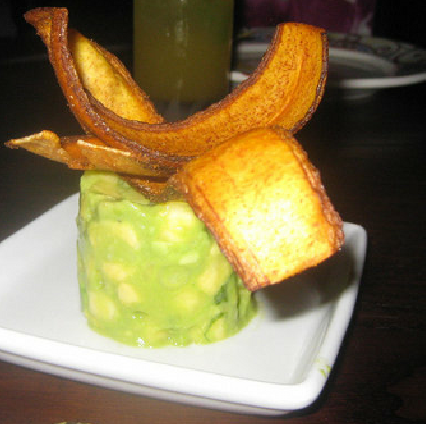
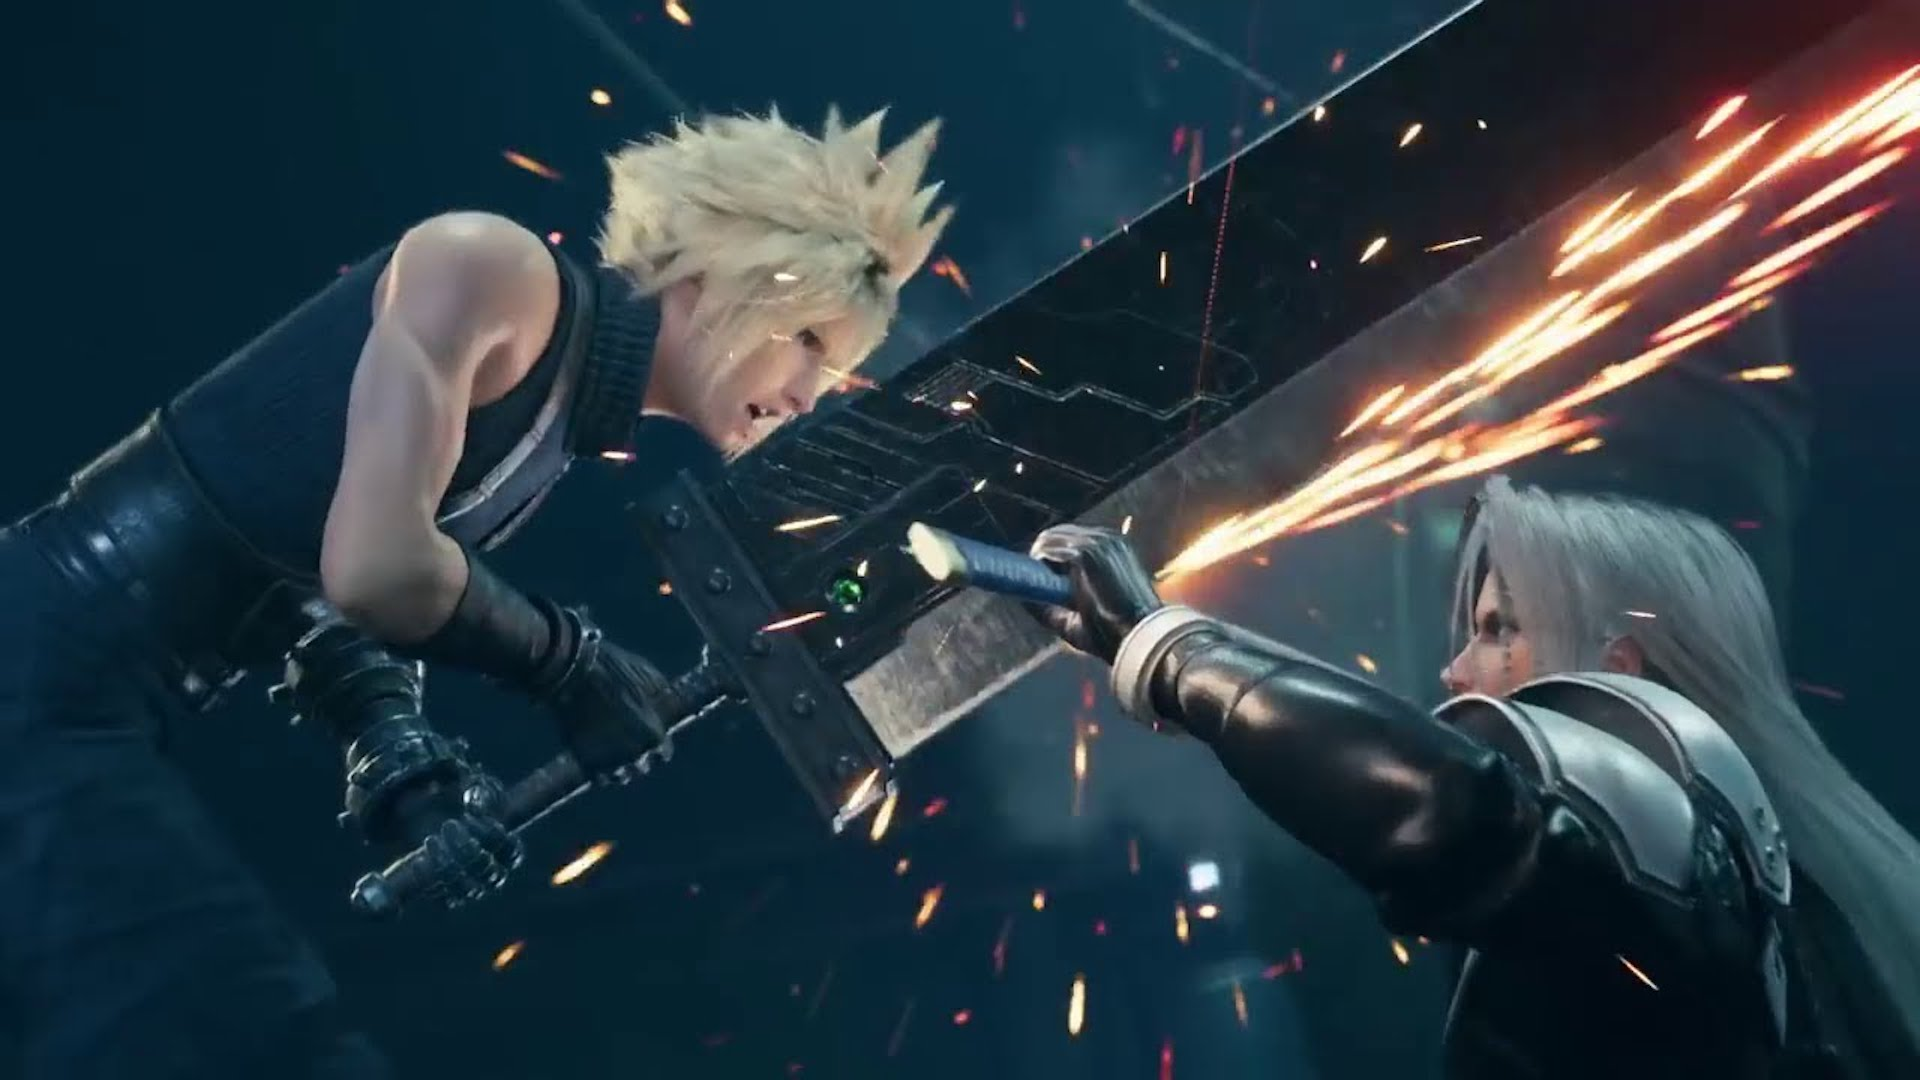
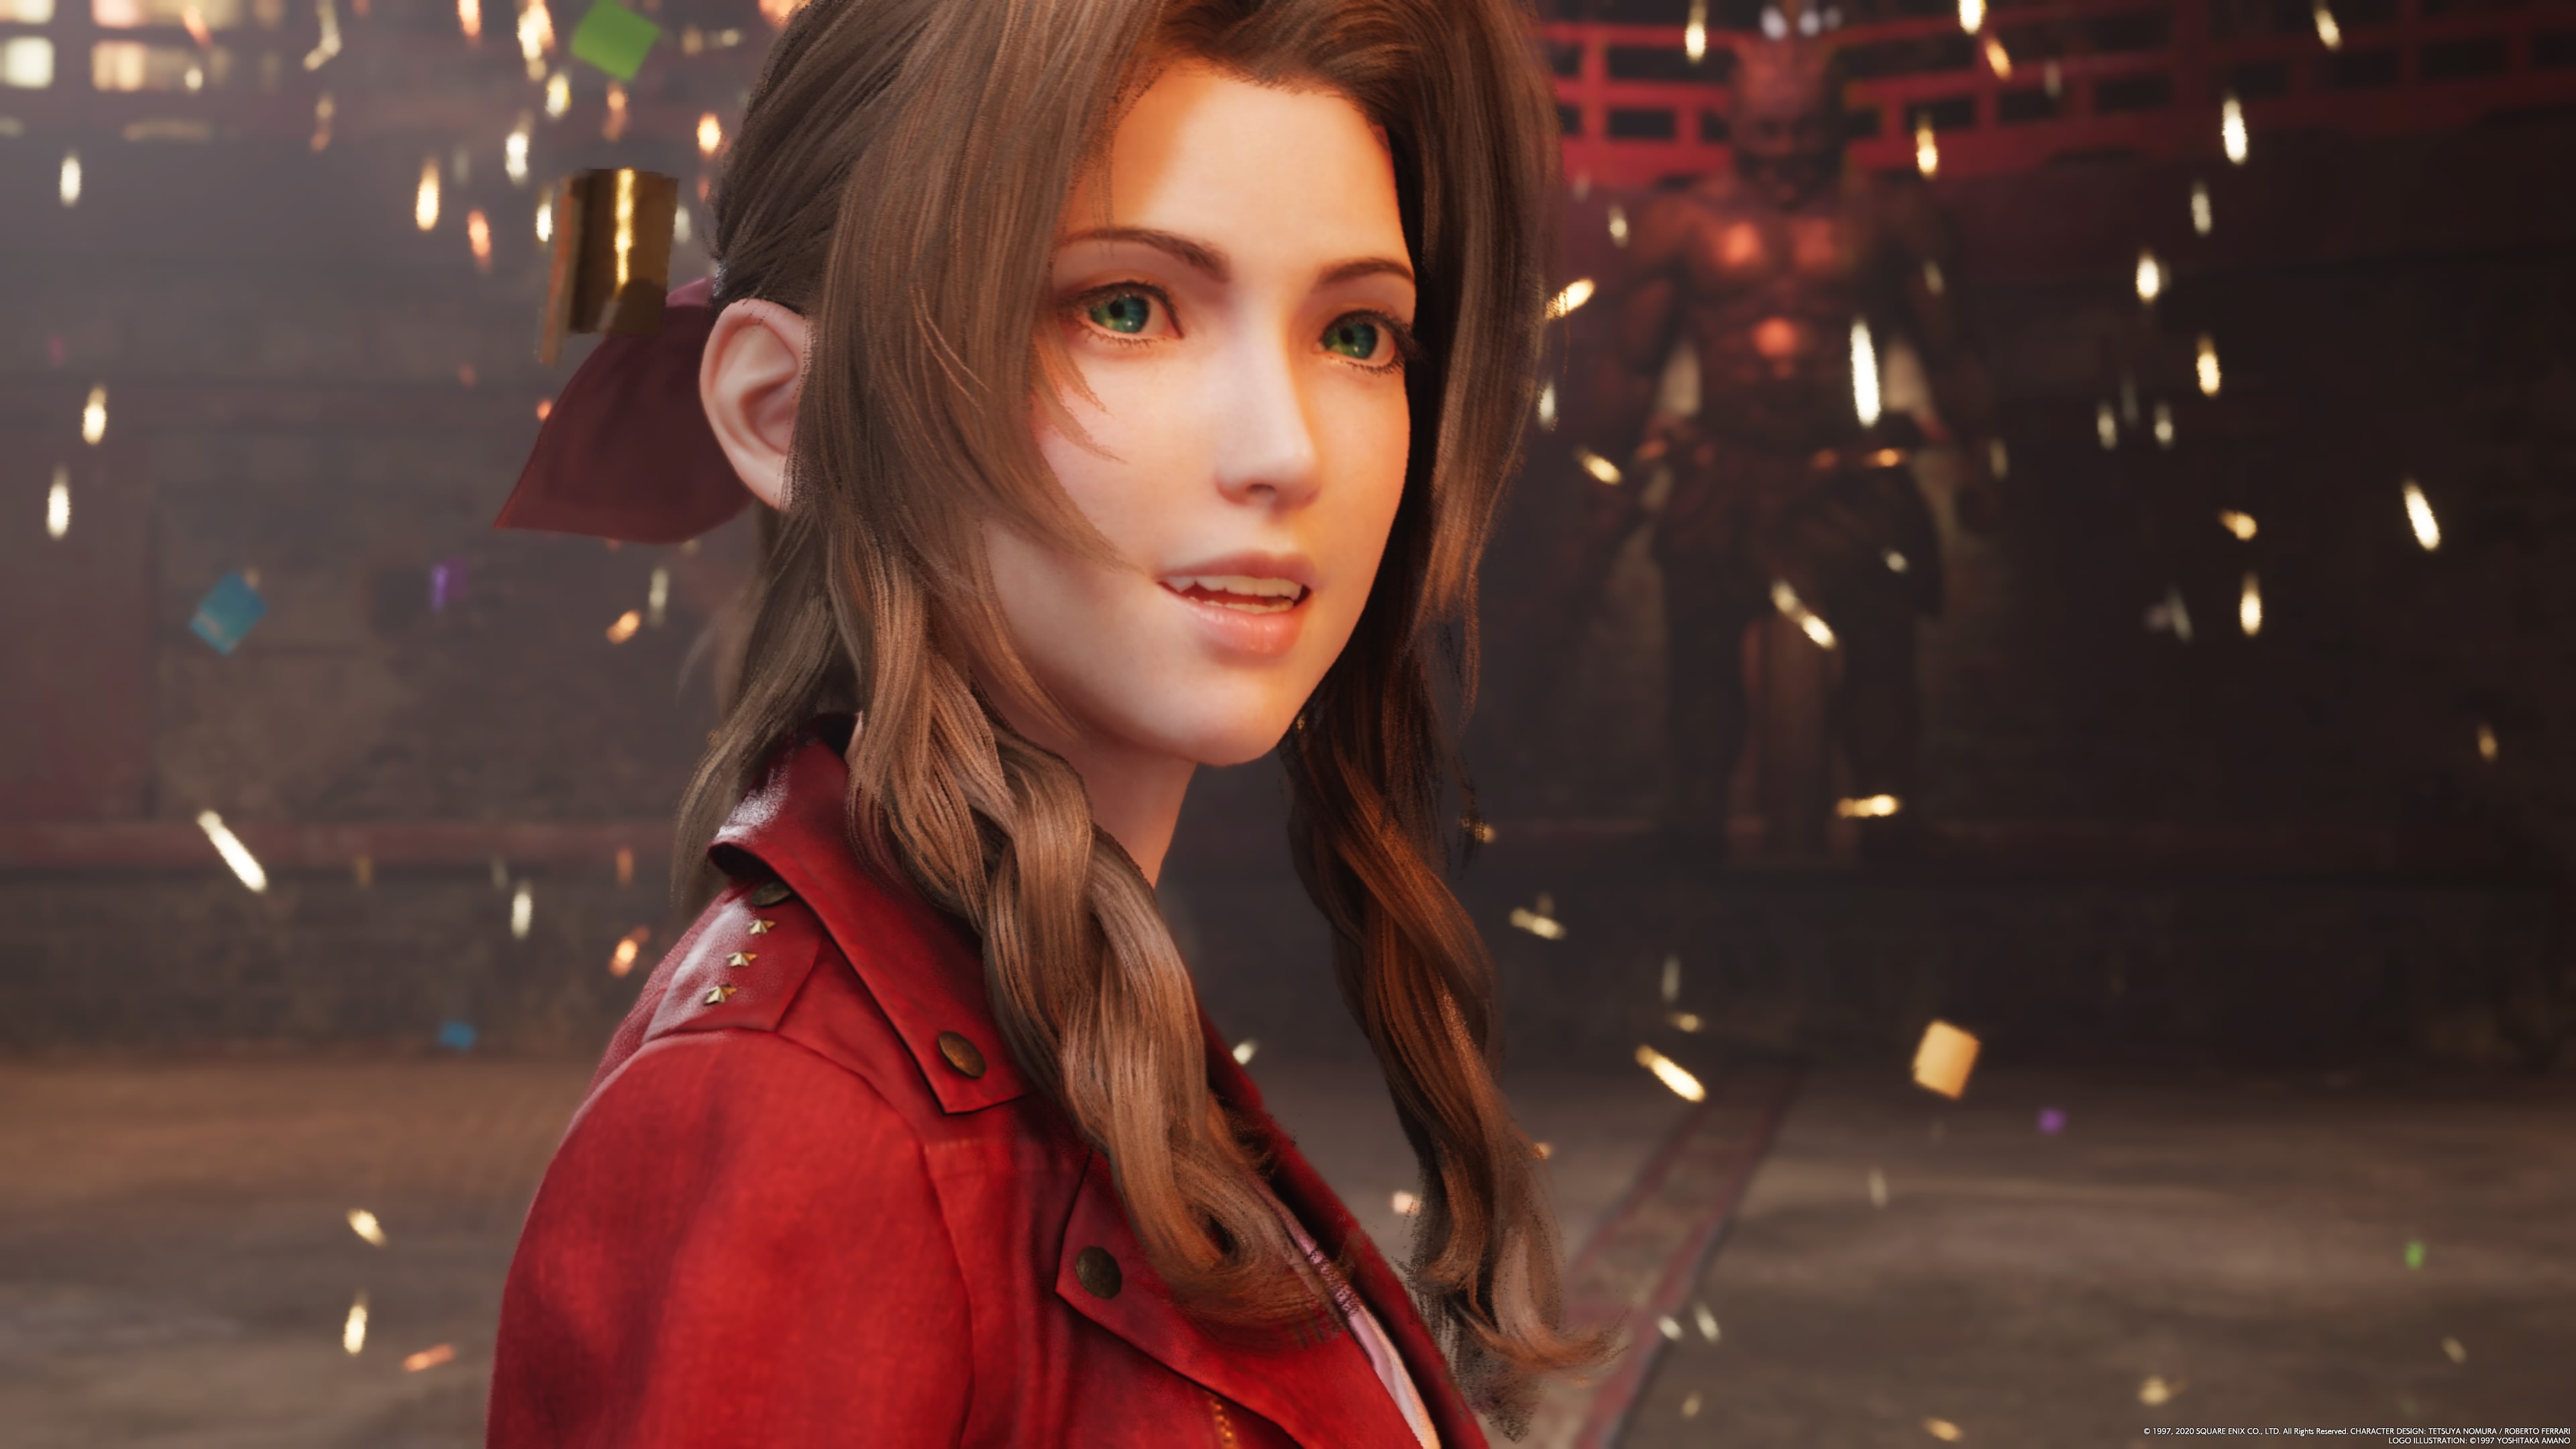
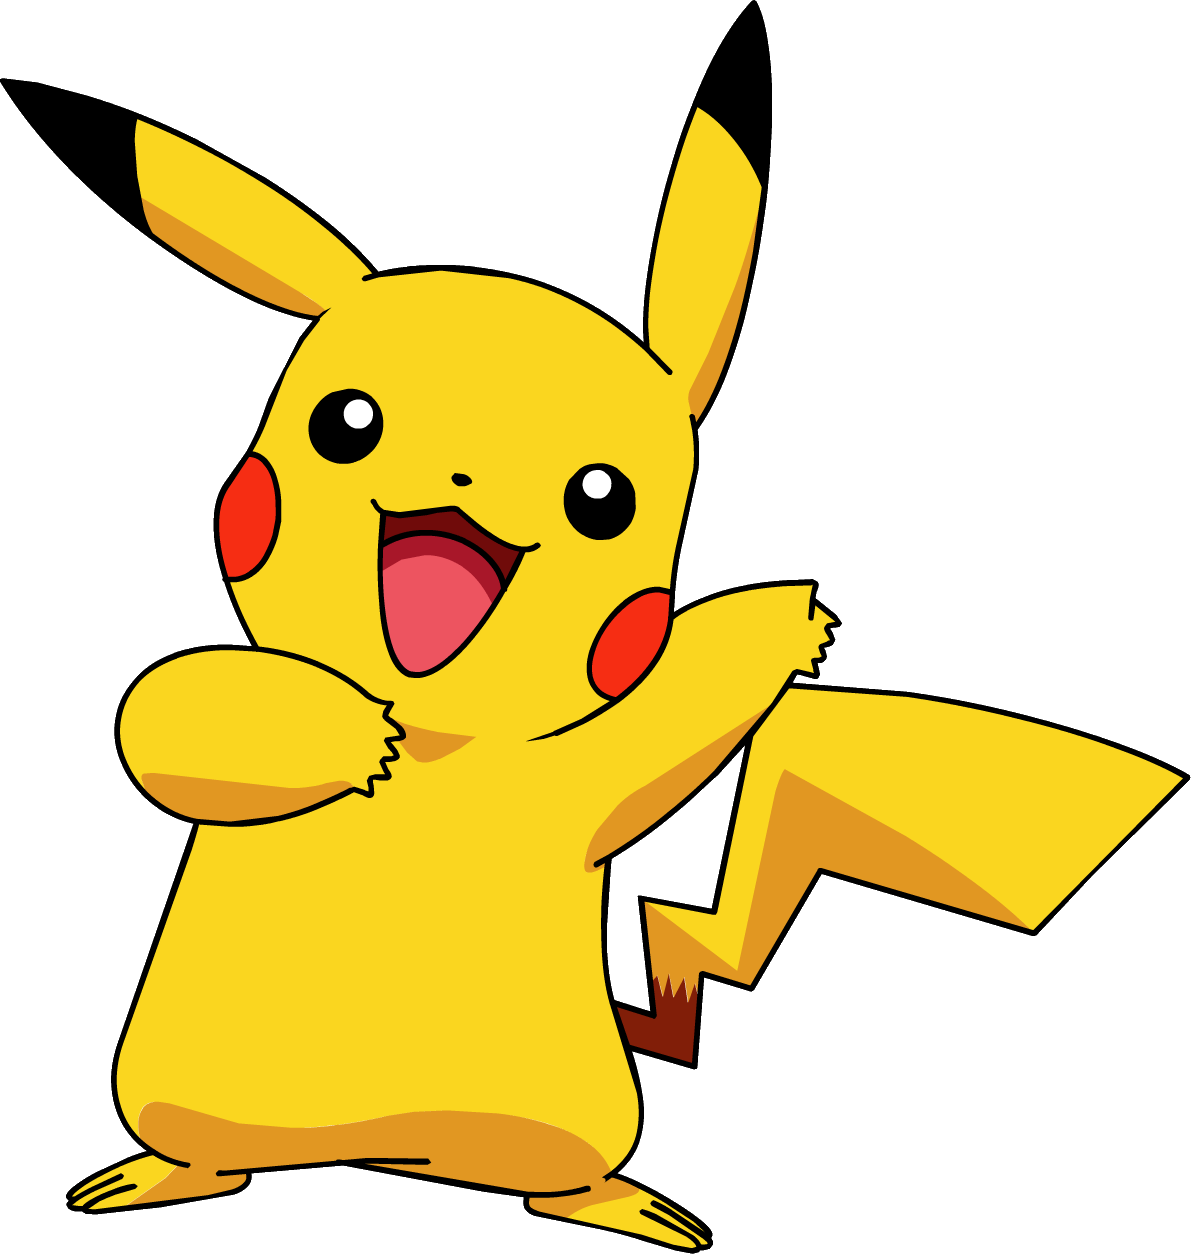
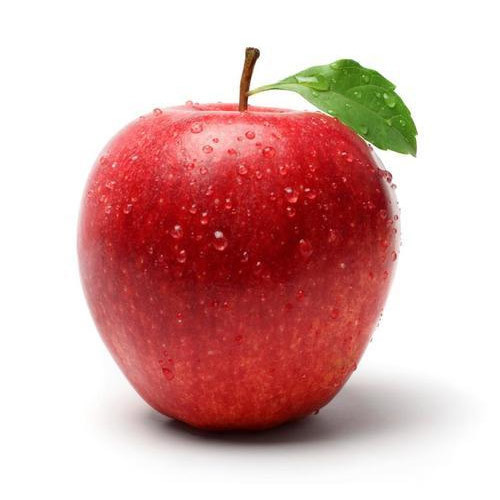
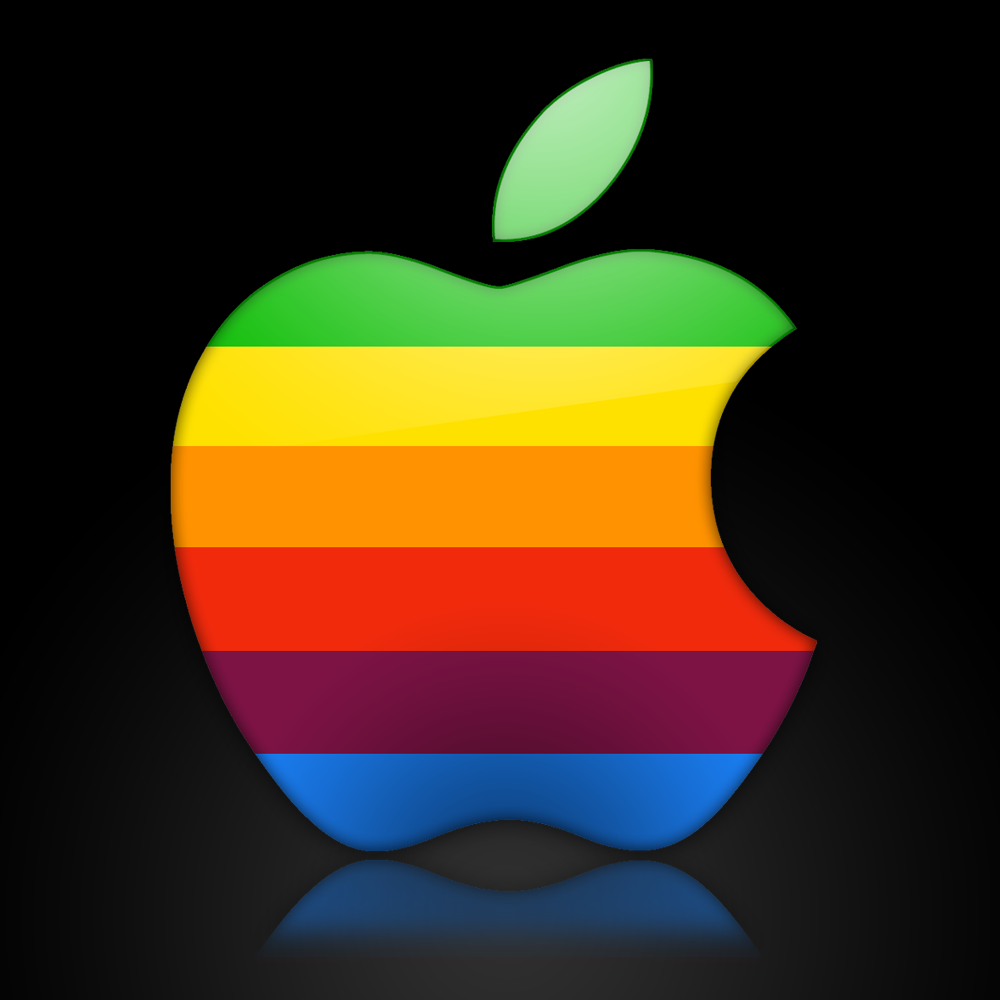
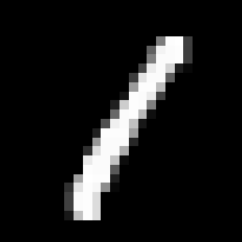

In [12]:
# Specify the paths to your images
image_paths = ['Images/guacamole.png', 'Images/fight.png',  'Images/aerith.png',  
               'Images/pikachu.png',  'Images/apple.png', 'Images/rainbow apple.png', 'Images/one.png']
# give some text for your pictures
texts = ["A photo of a guacamole", "A picture of a fight", "A picture of a girl", 
         "A picture of pikachu", "a picture of an apple", "a picture of a rainbow apple", "a picture of one"]
display_similarity(image_paths, texts, 'image')


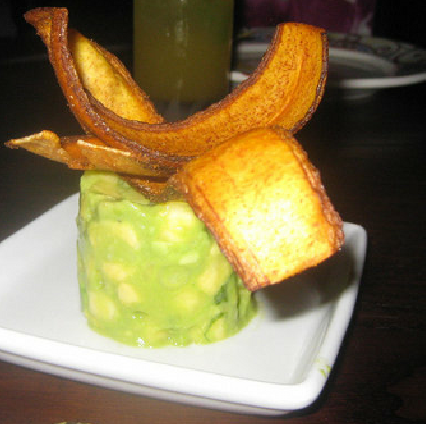
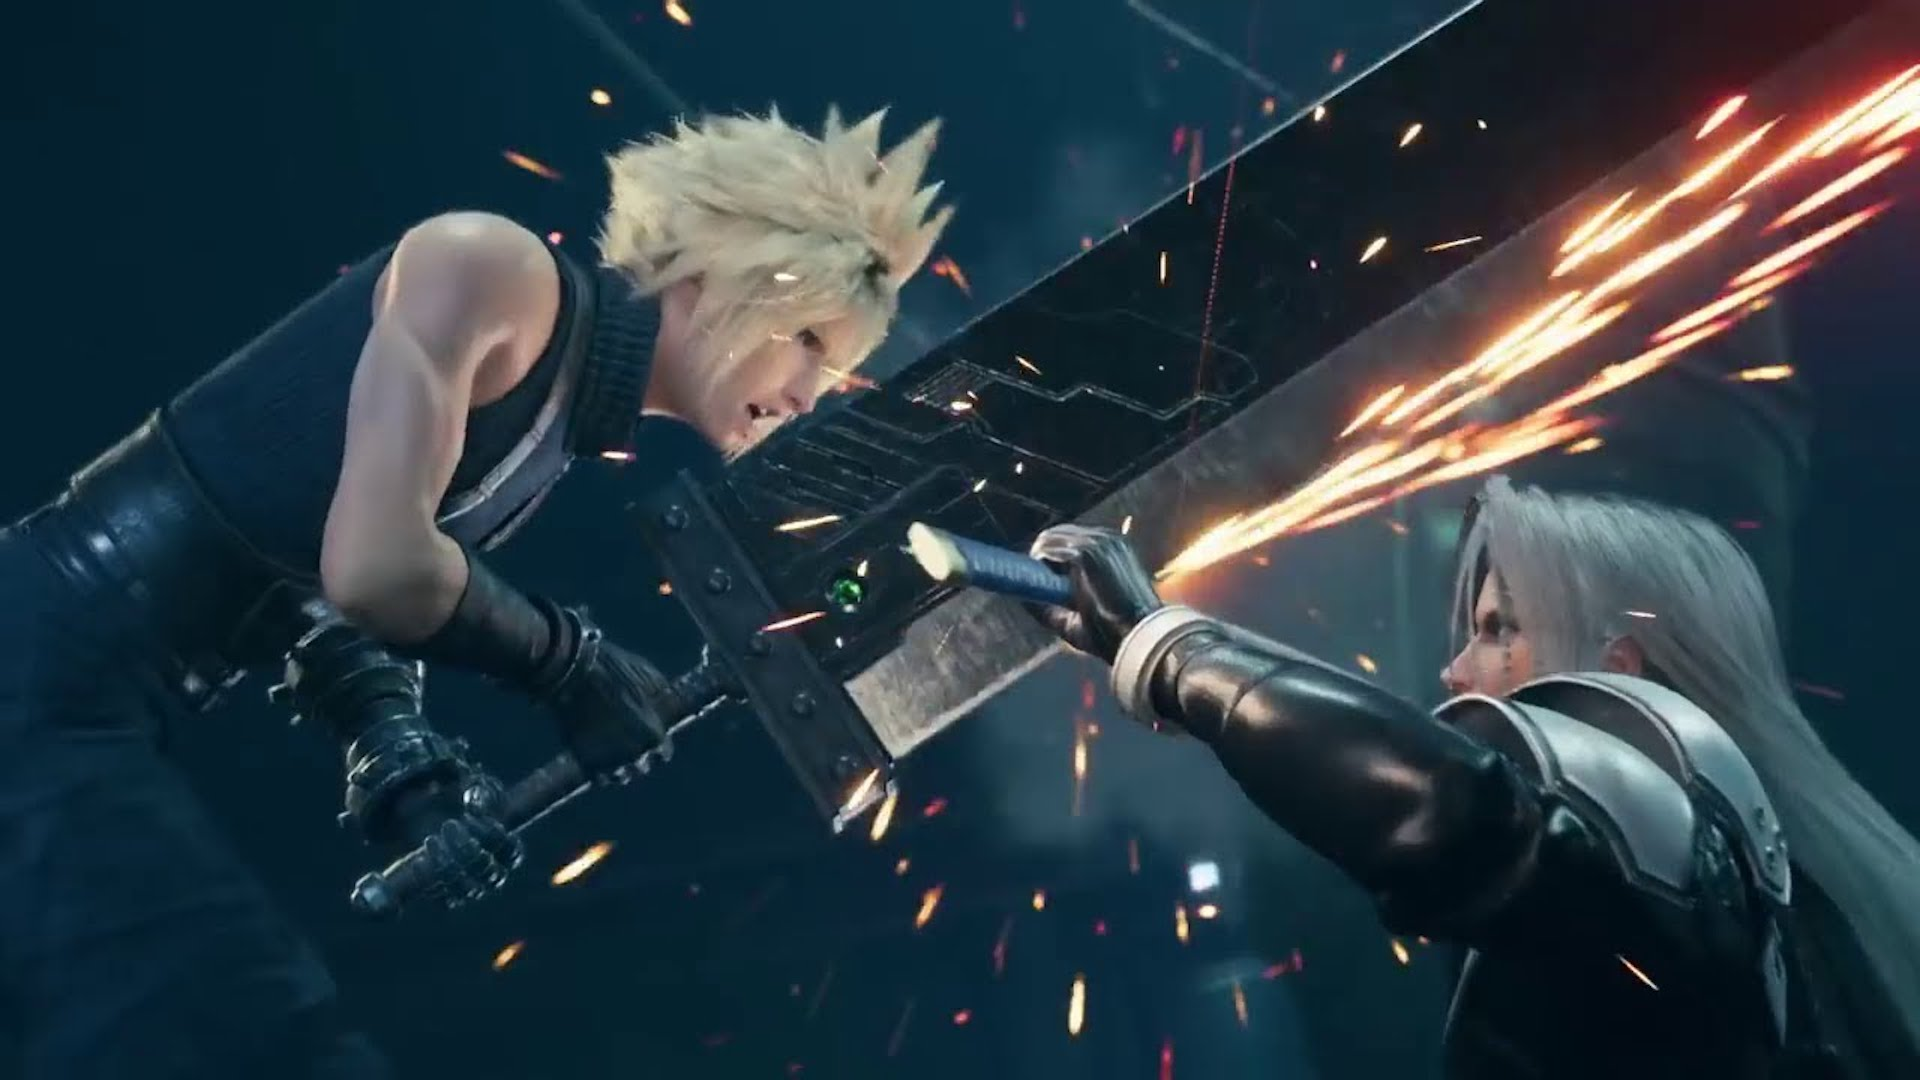
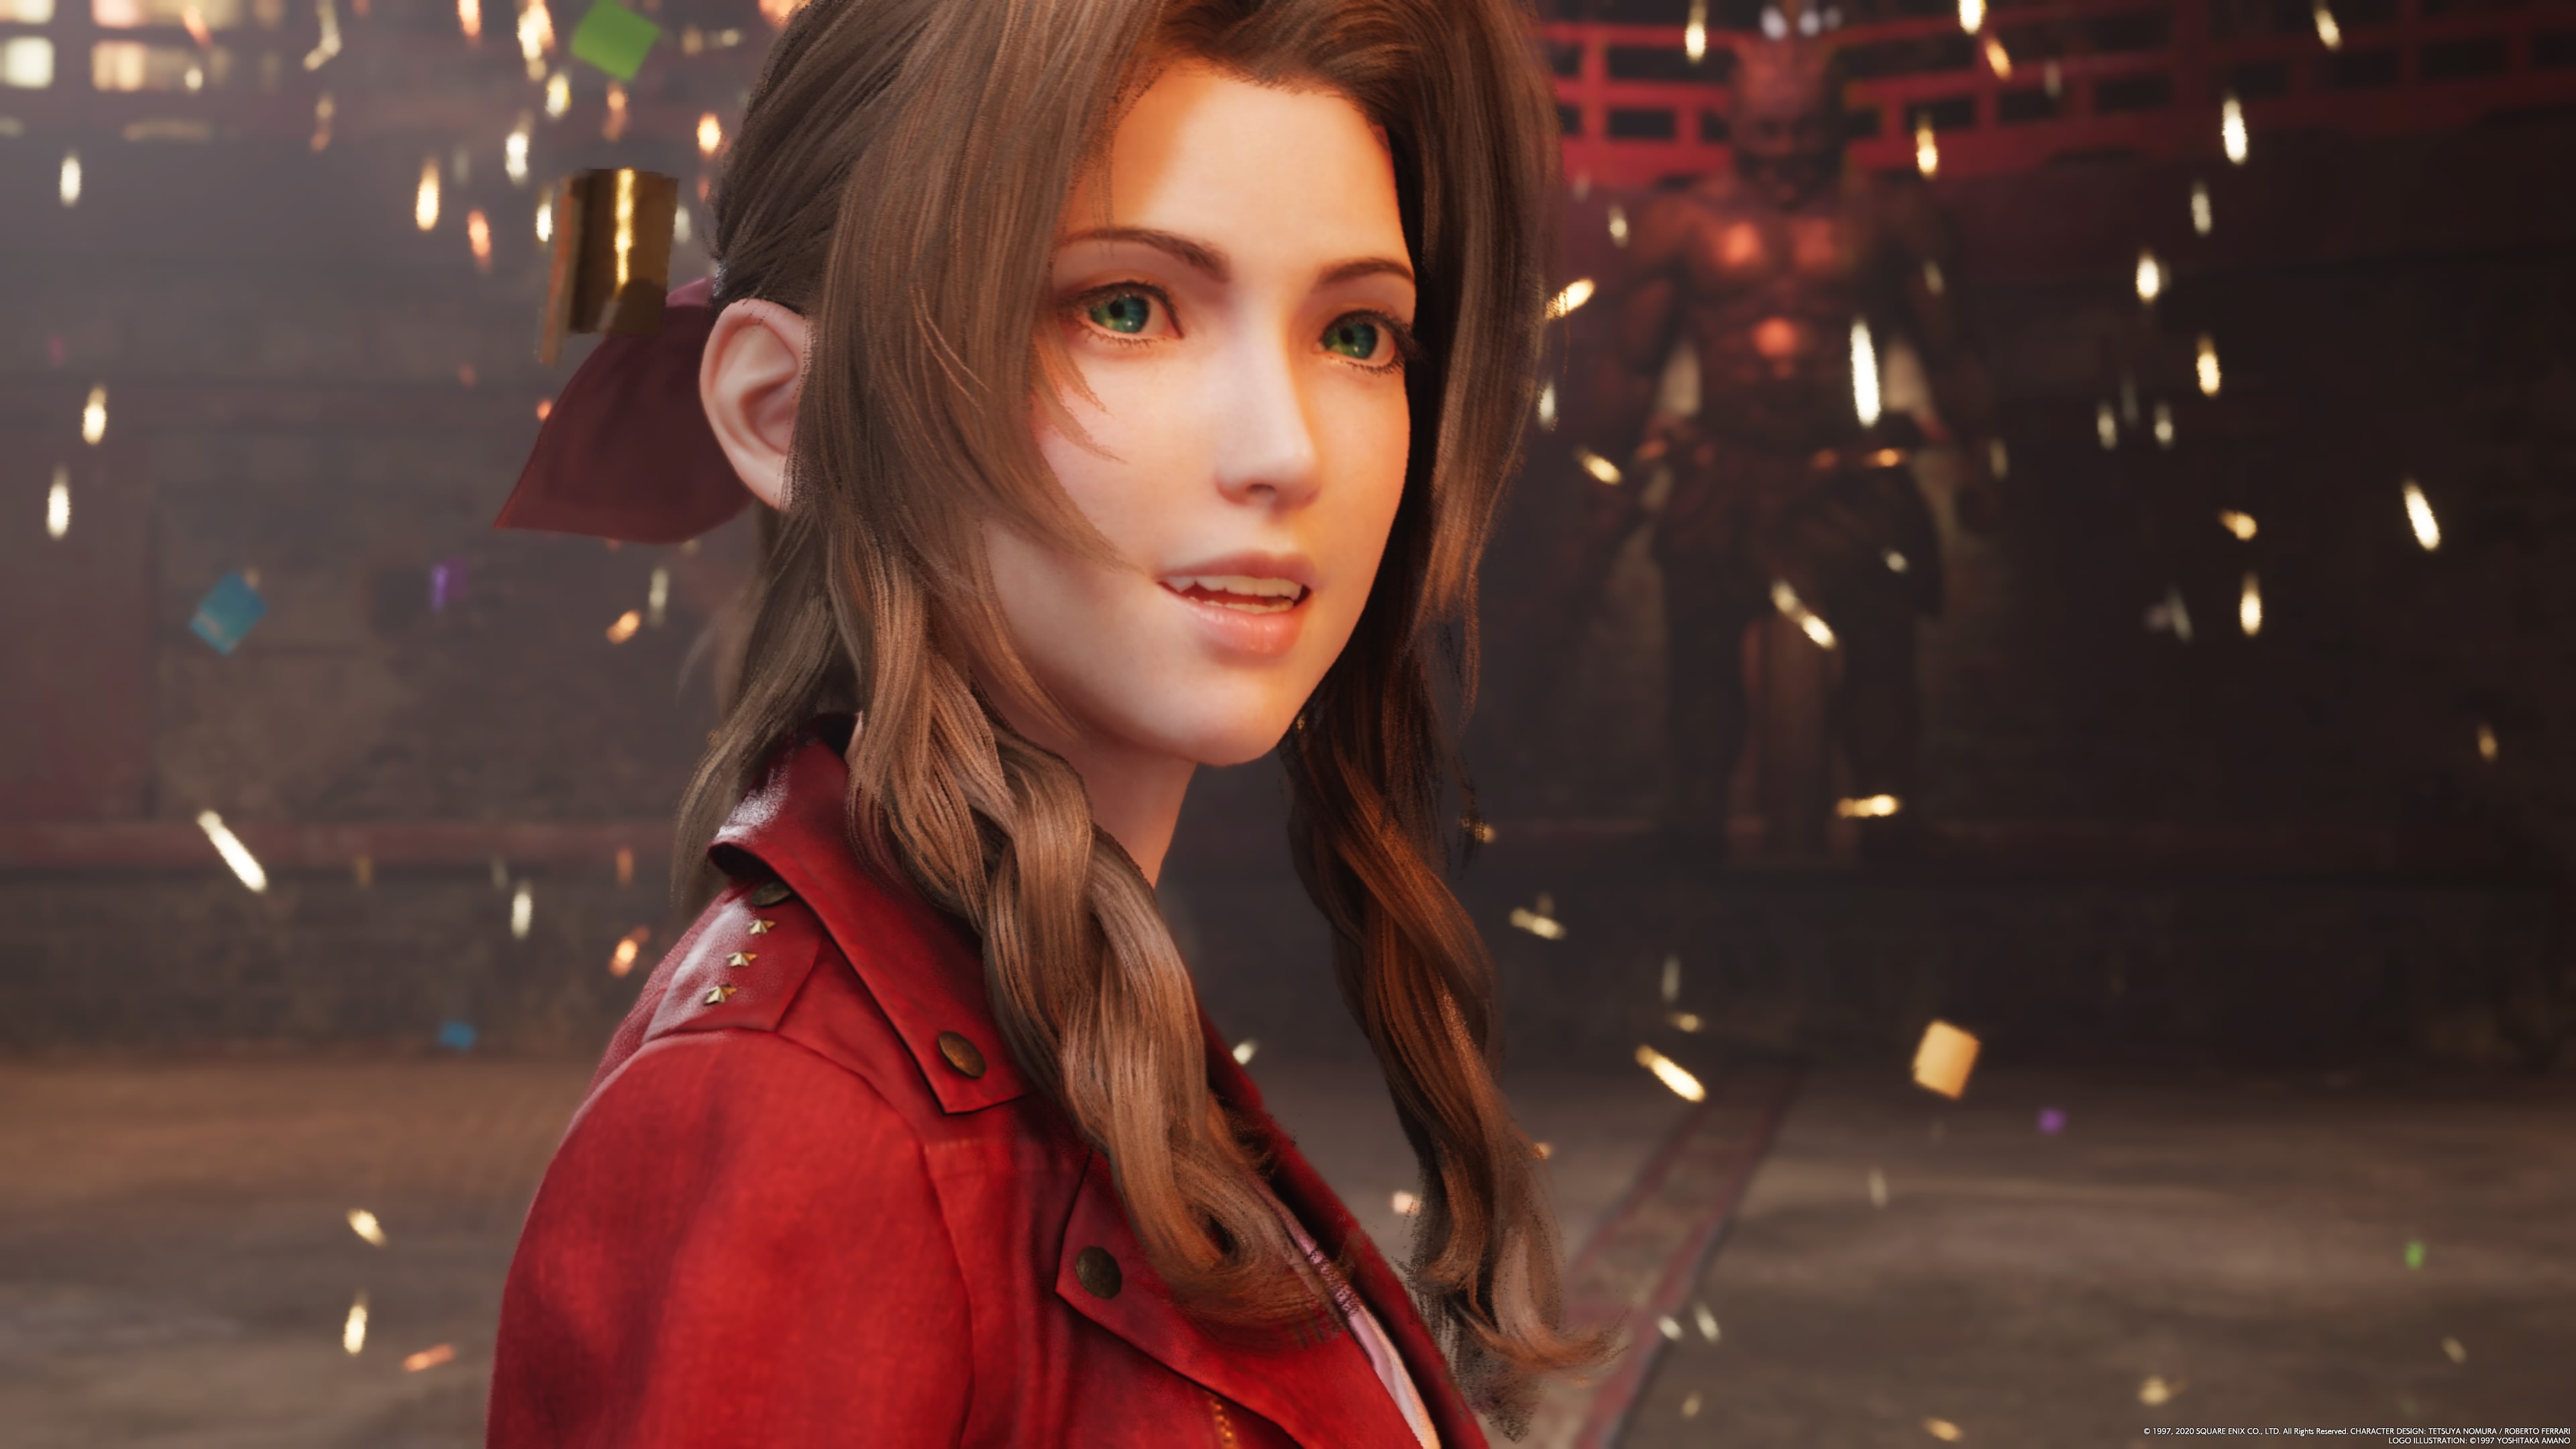
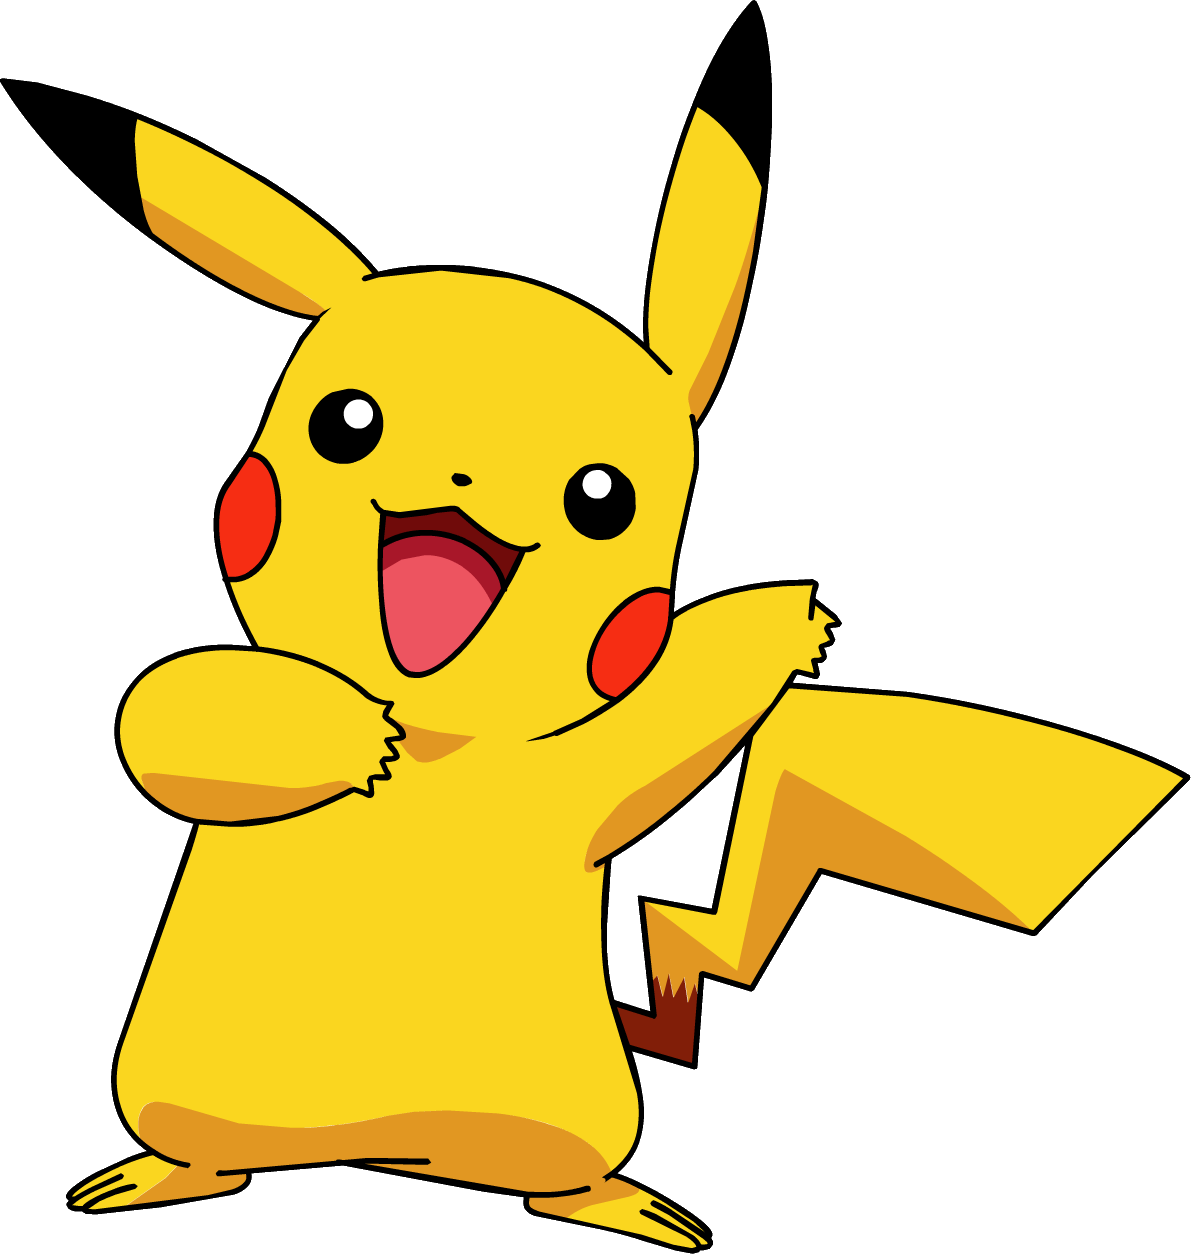
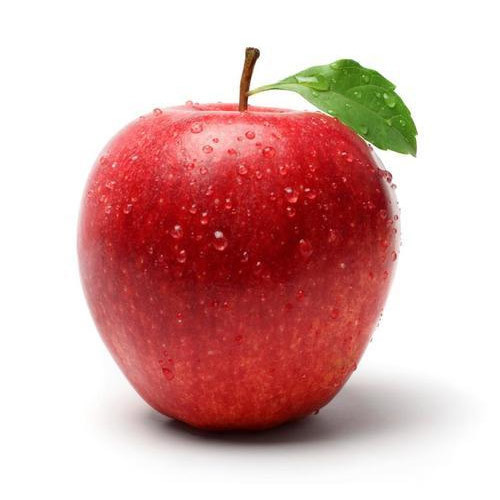
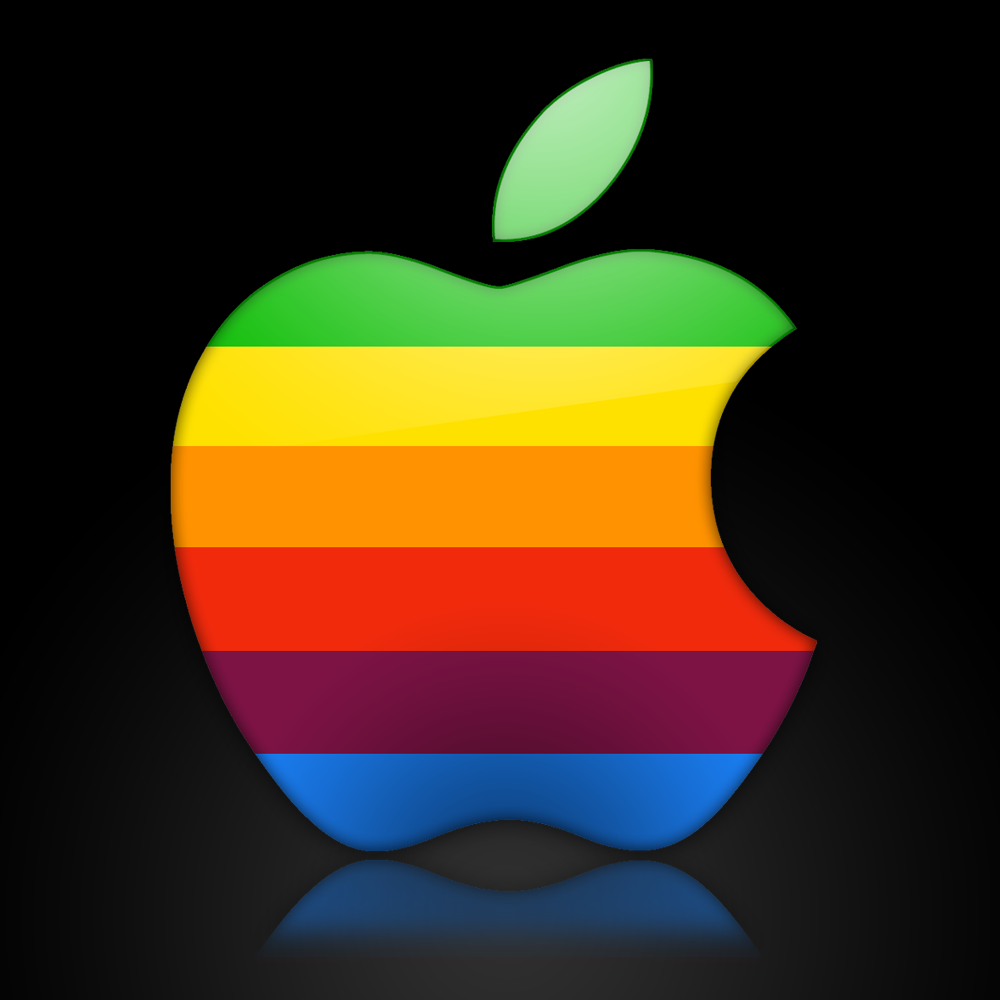
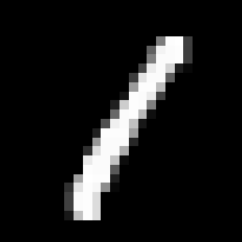

In [13]:
# Specify the paths to your images
image_paths = ['Images/guacamole.png', 'Images/fight.png',  'Images/aerith.png',  
               'Images/pikachu.png',  'Images/apple.png', 'Images/rainbow apple.png', 'Images/one.png']
# give some text for your pictures
texts = ["A photo of a guacamole", "A picture of a fight", "A picture of a girl", 
         "A picture of pikachu", "a picture of an apple", "a picture of a rainbow apple", "a picture of one"]
display_similarity(image_paths, texts, 'text')


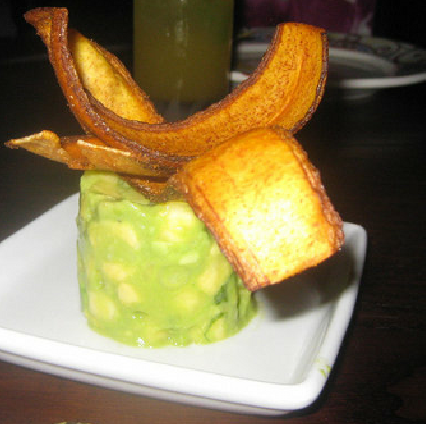
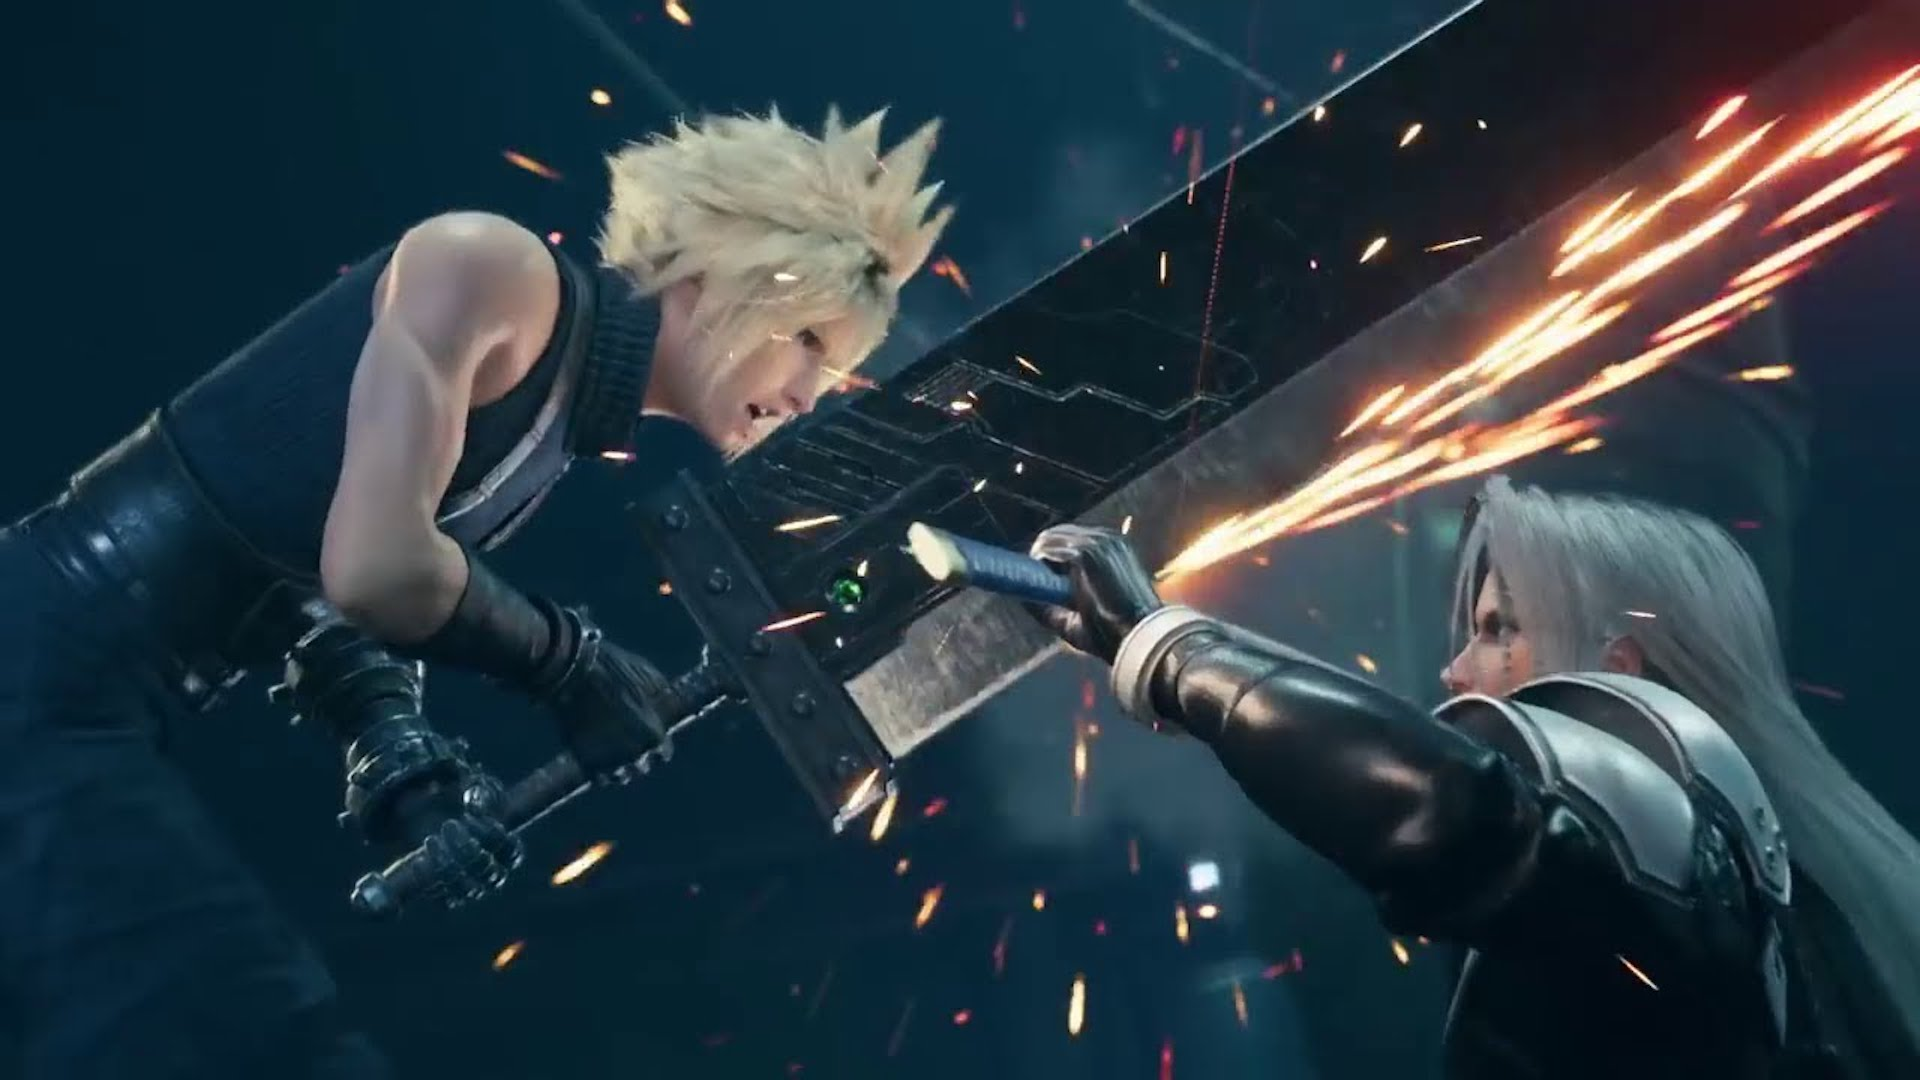
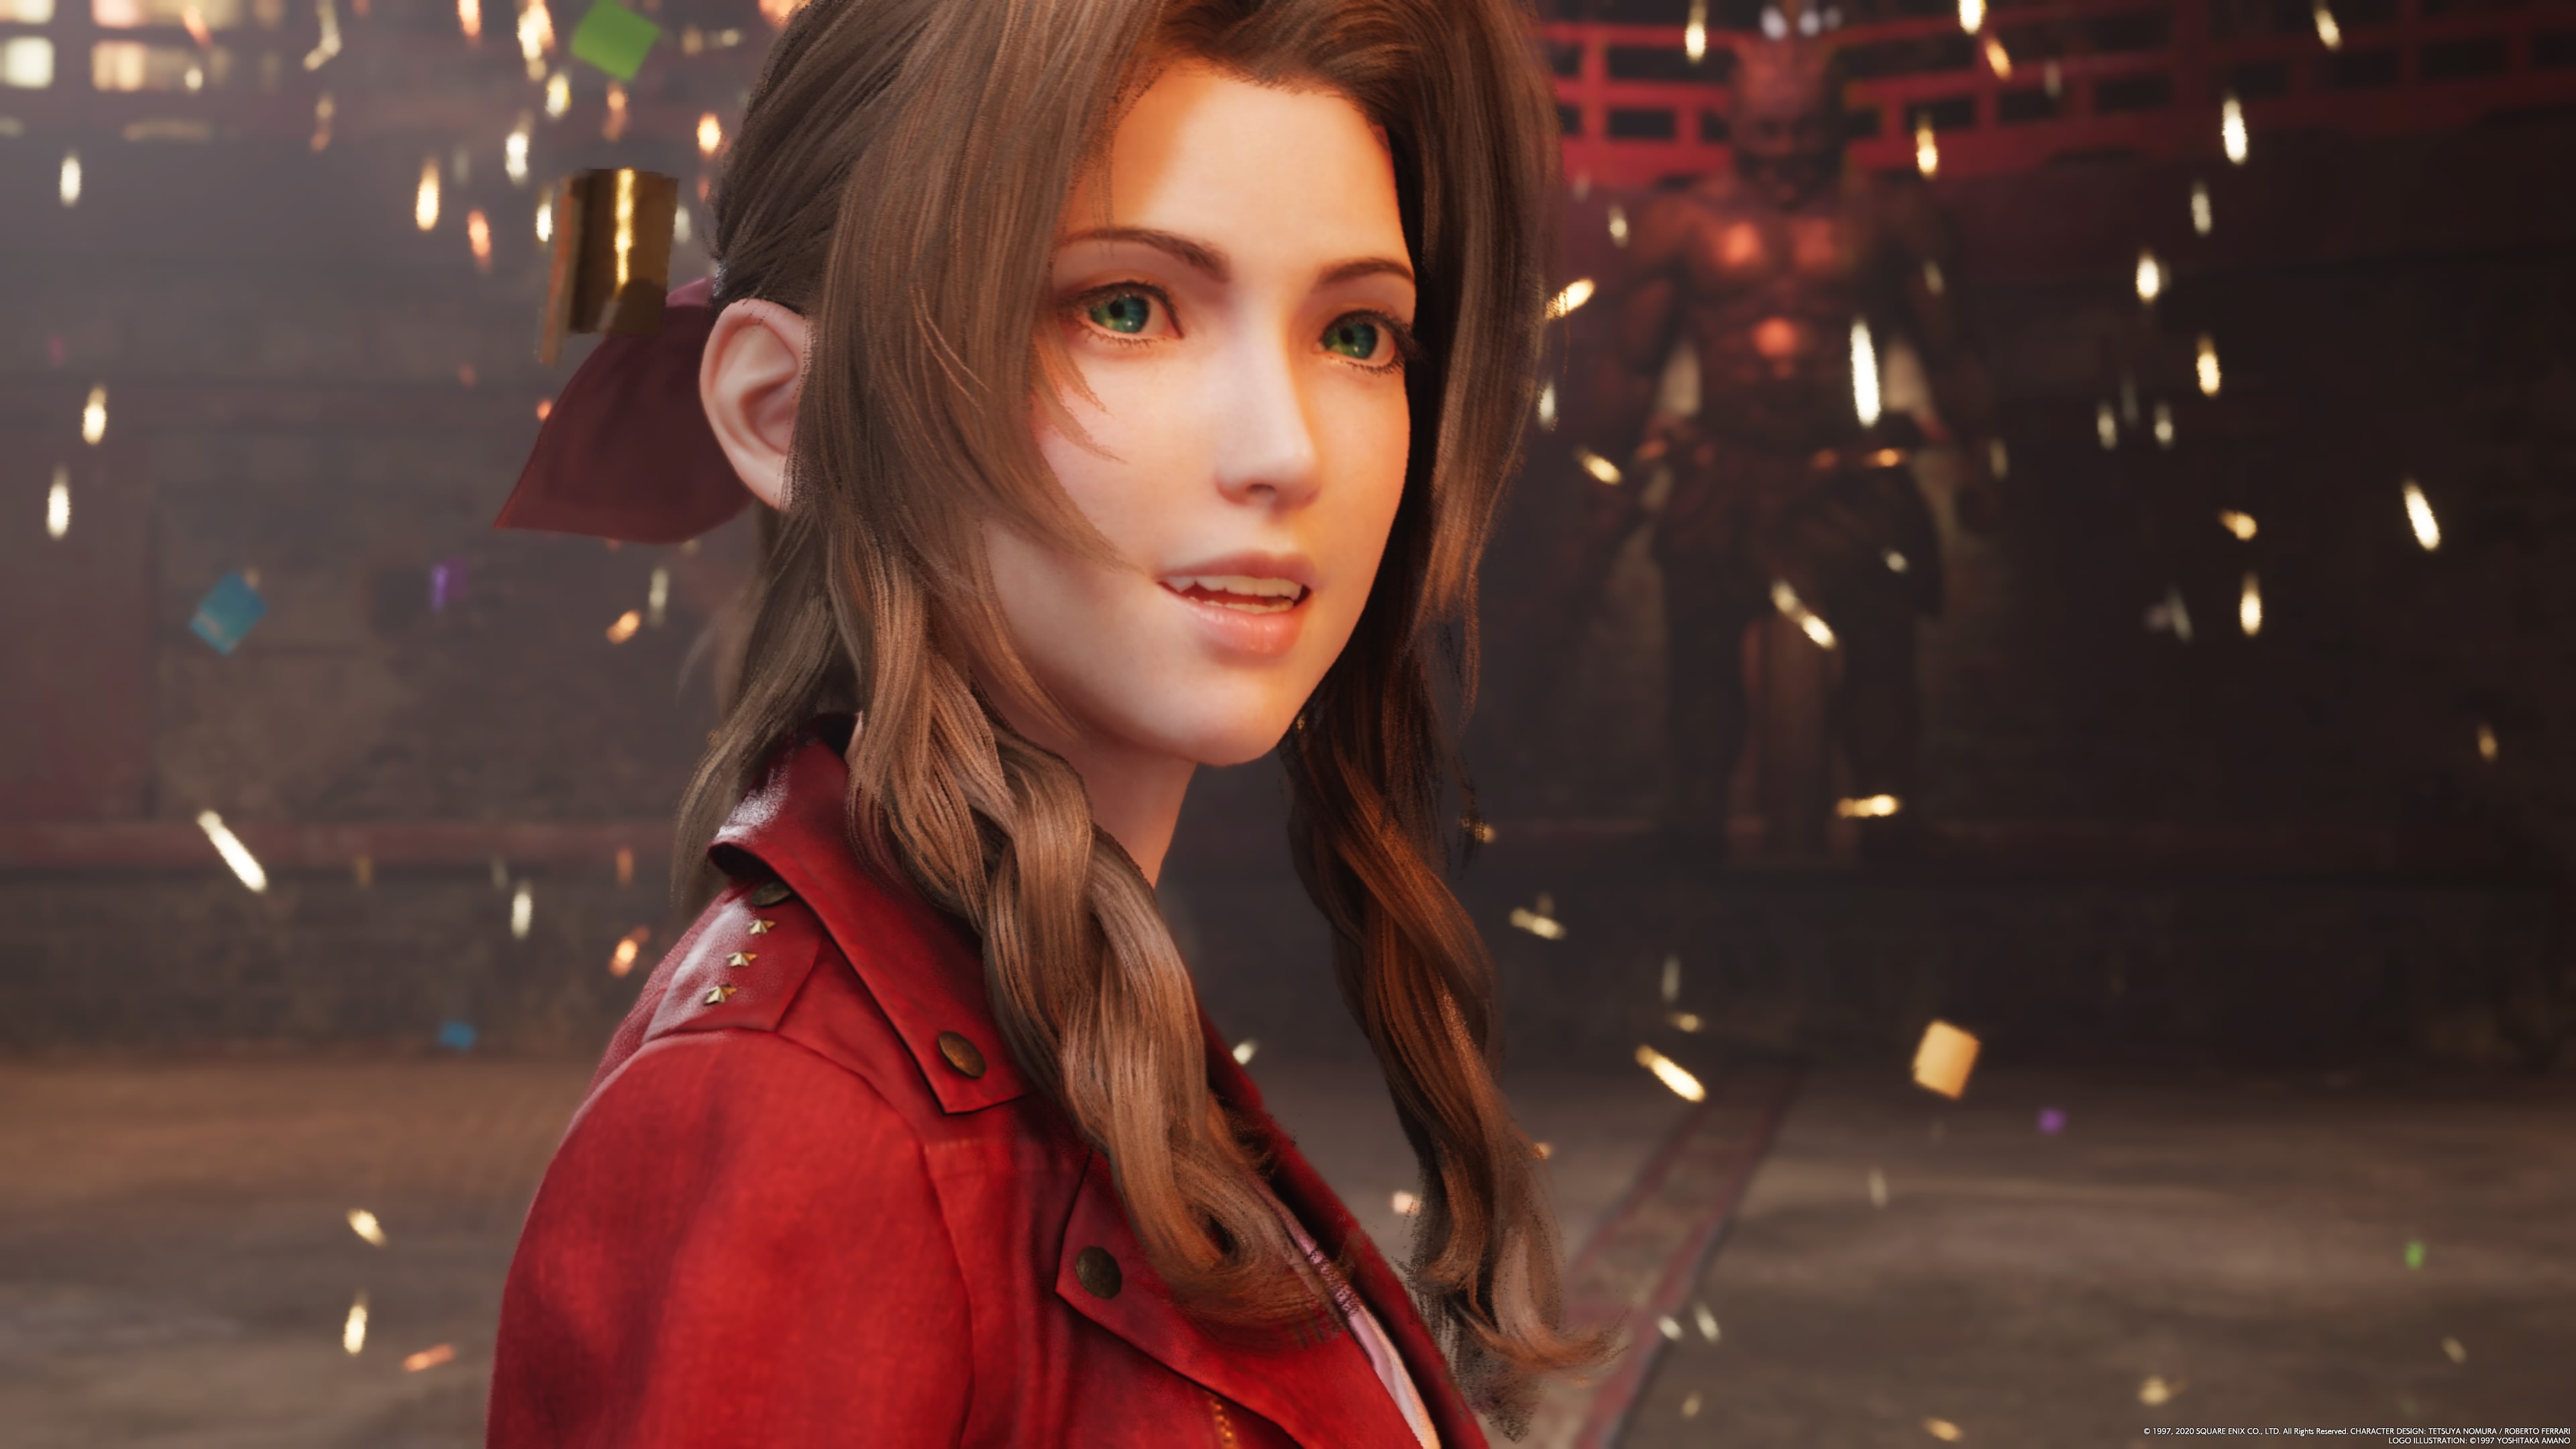
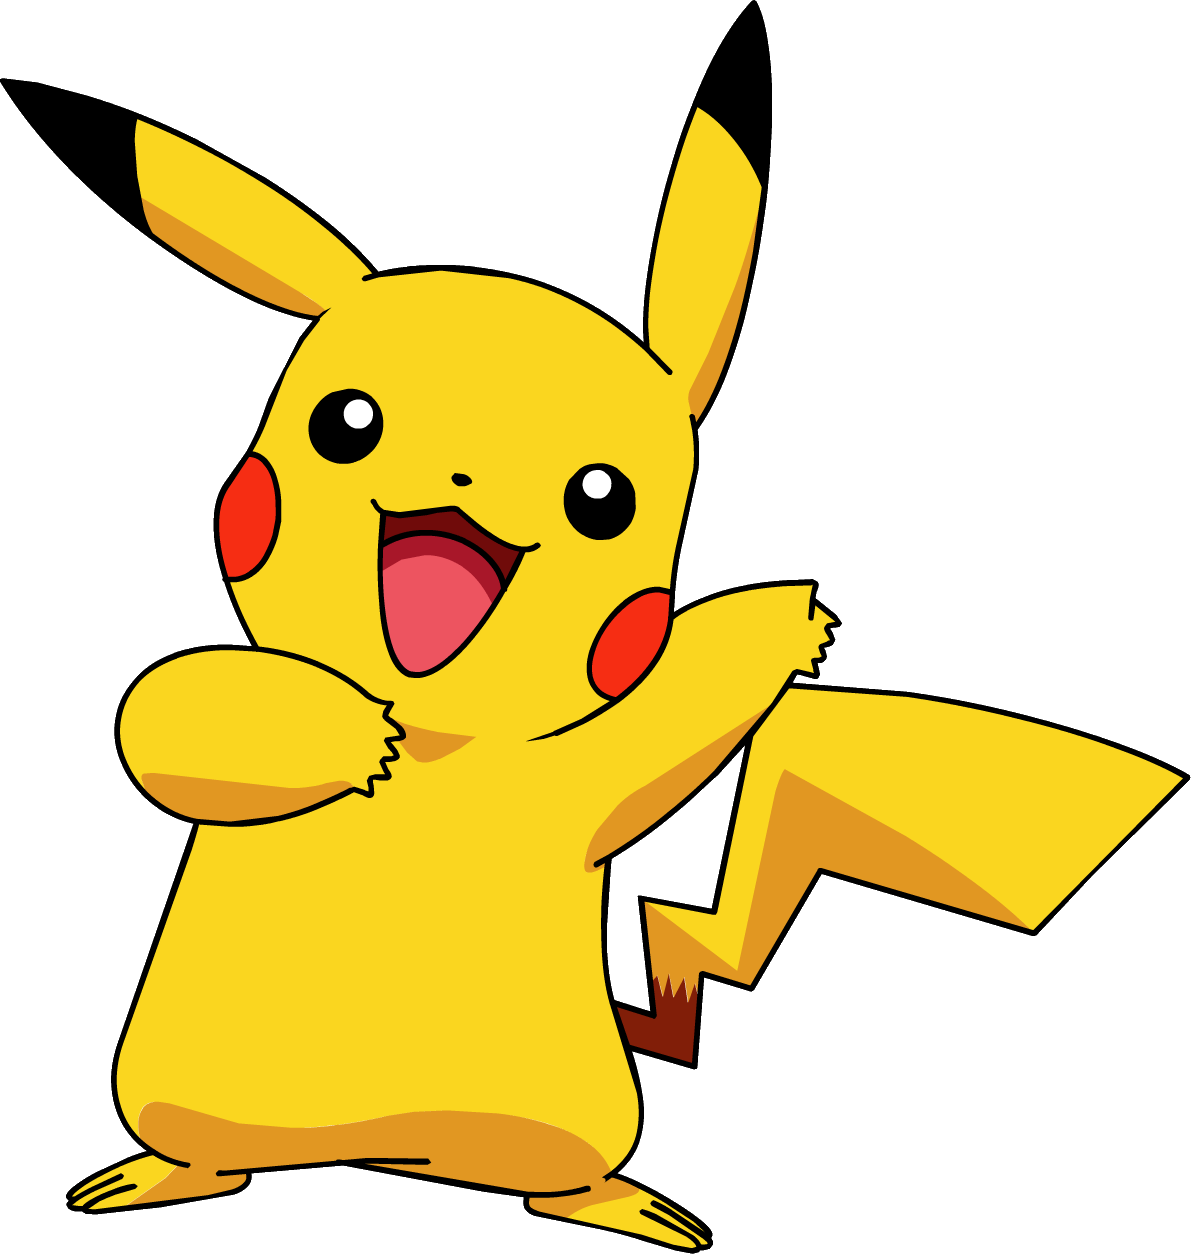
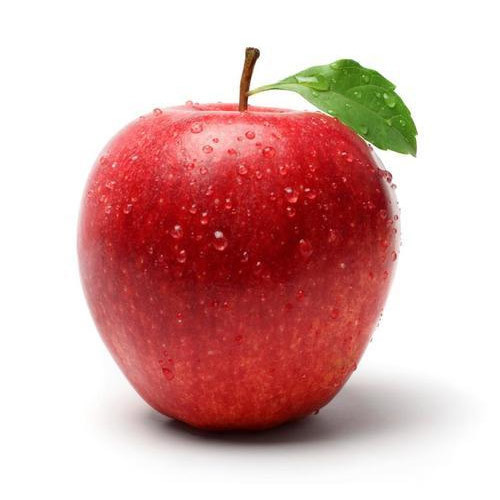
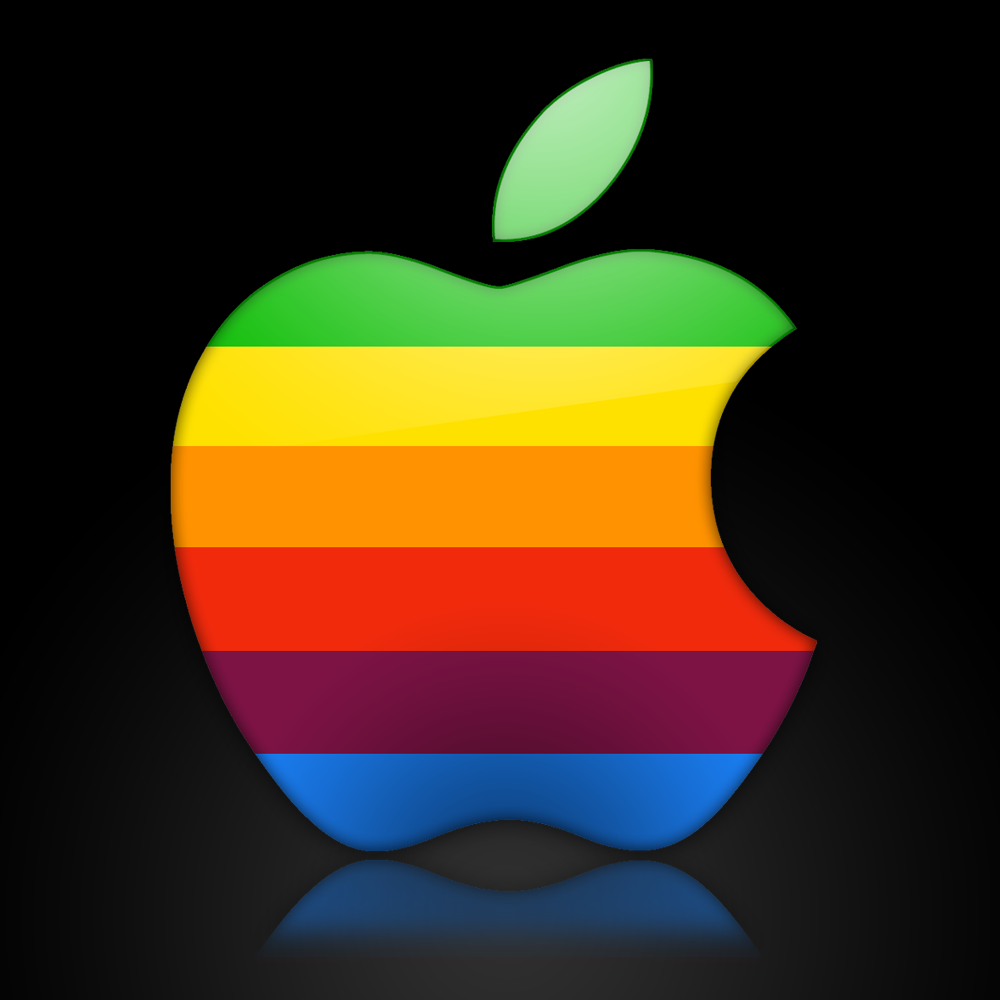
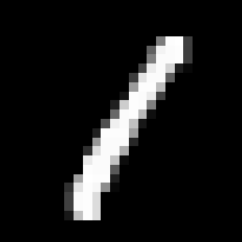

In [14]:
# Specify the paths to your images
image_paths = ['Images/guacamole.png', 'Images/fight.png',  'Images/aerith.png',  
               'Images/pikachu.png',  'Images/apple.png', 'Images/rainbow apple.png', 'Images/one.png']
# give some text for your pictures
texts = ["A girl", "A sword", "A number", "A food", "An animal", "A logo"]
display_similarity(image_paths, texts, 'image')


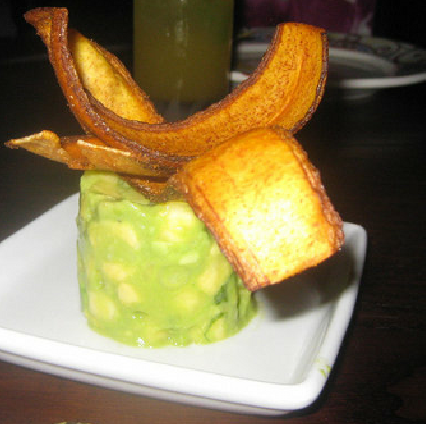
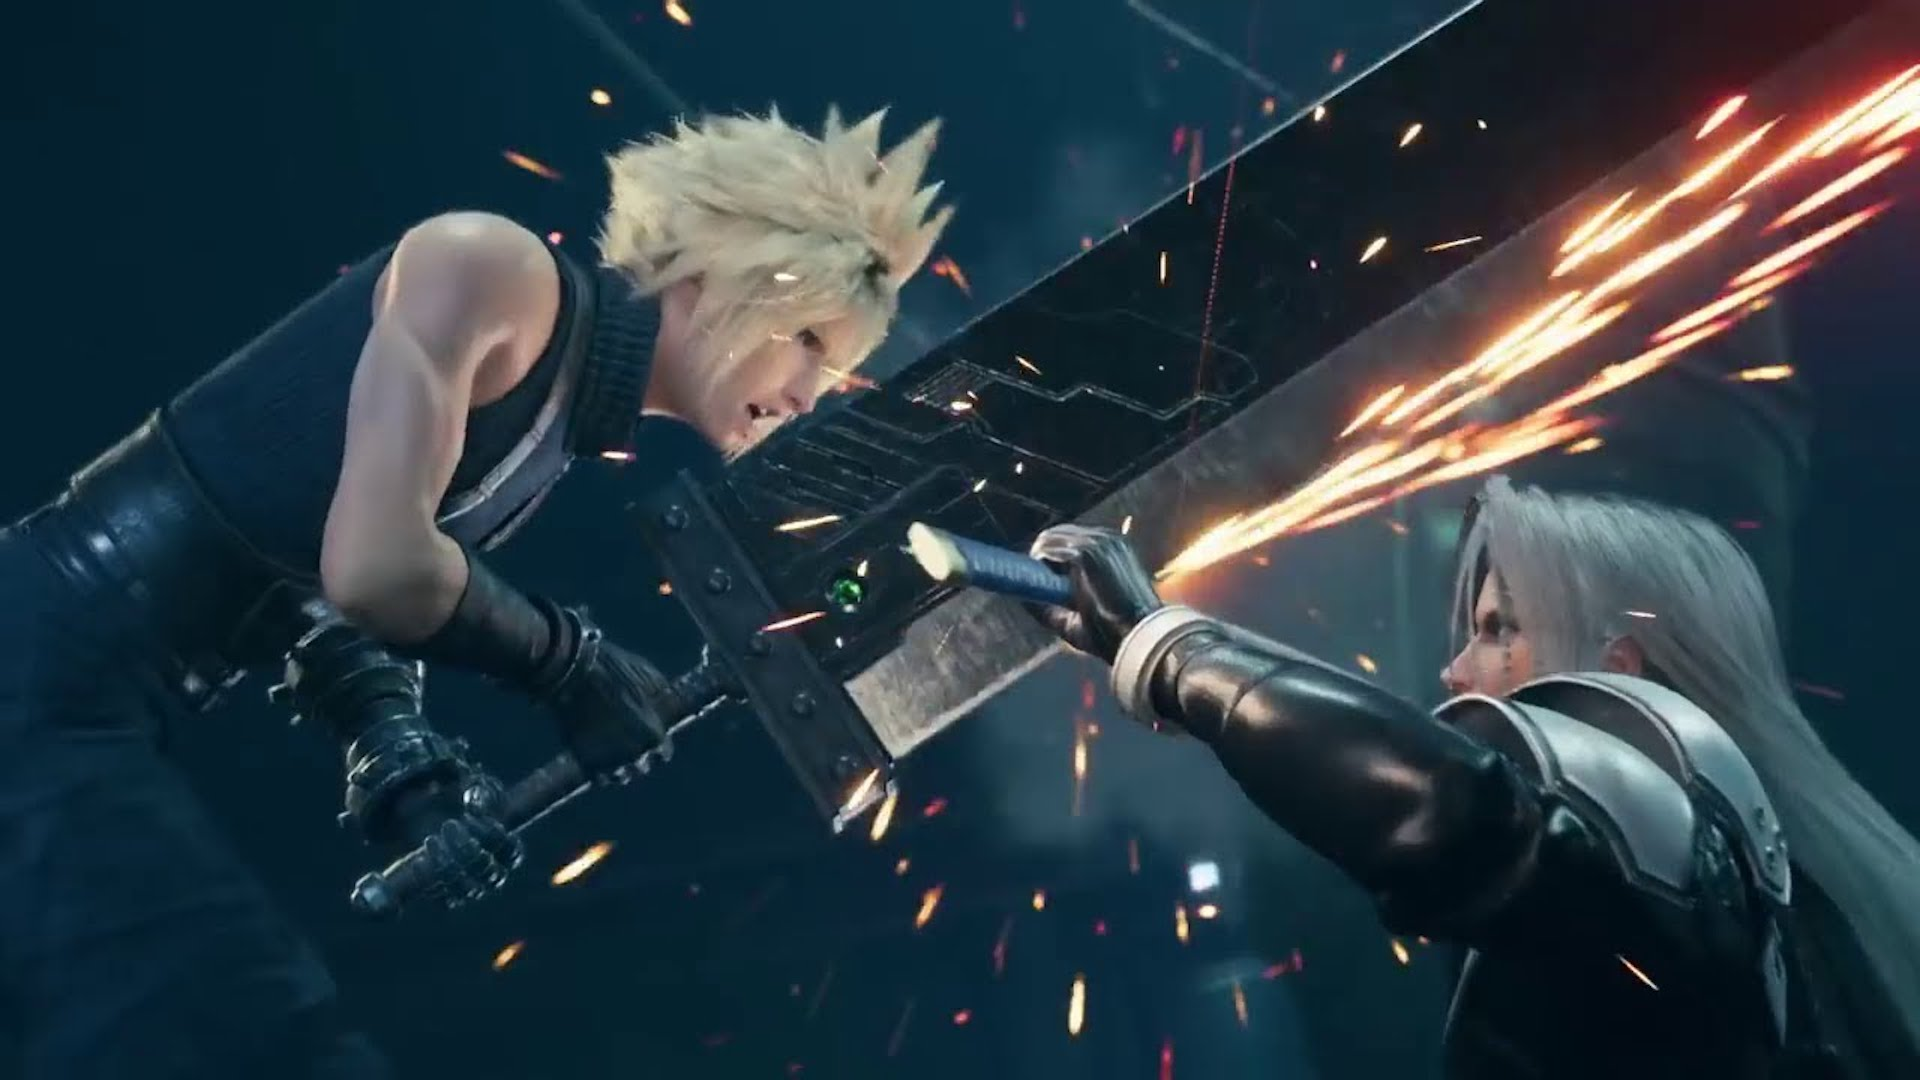
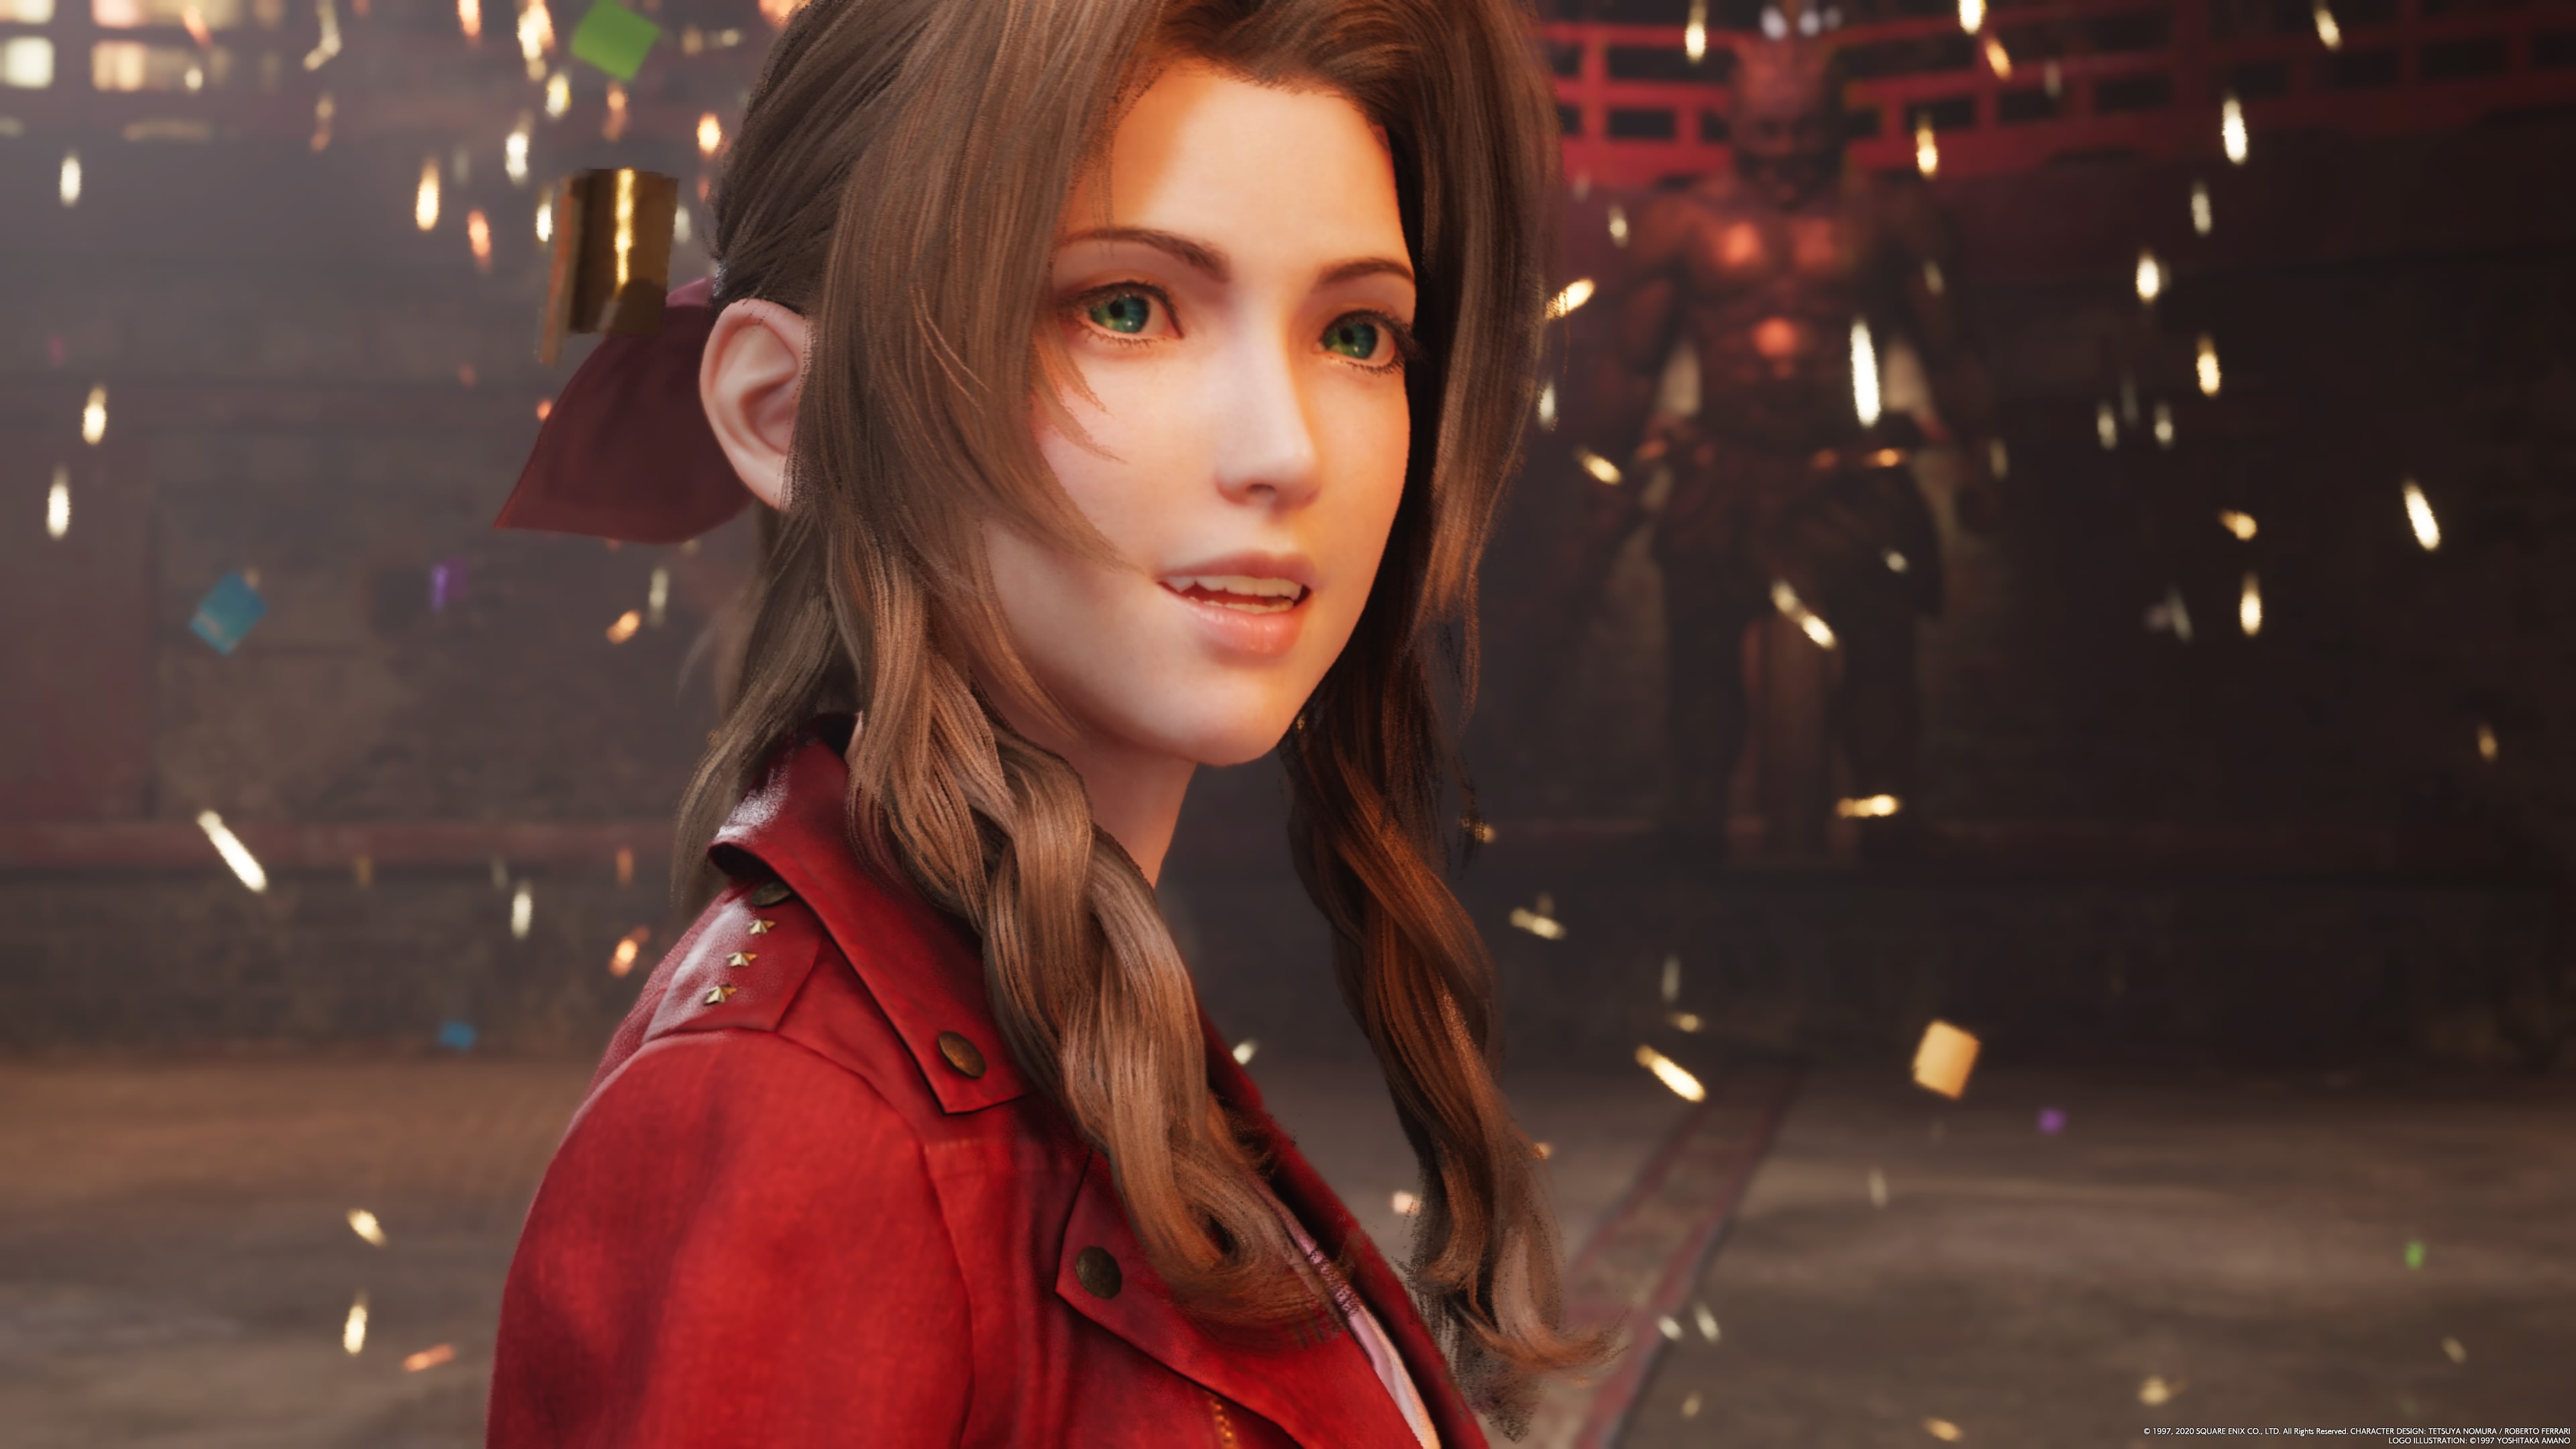
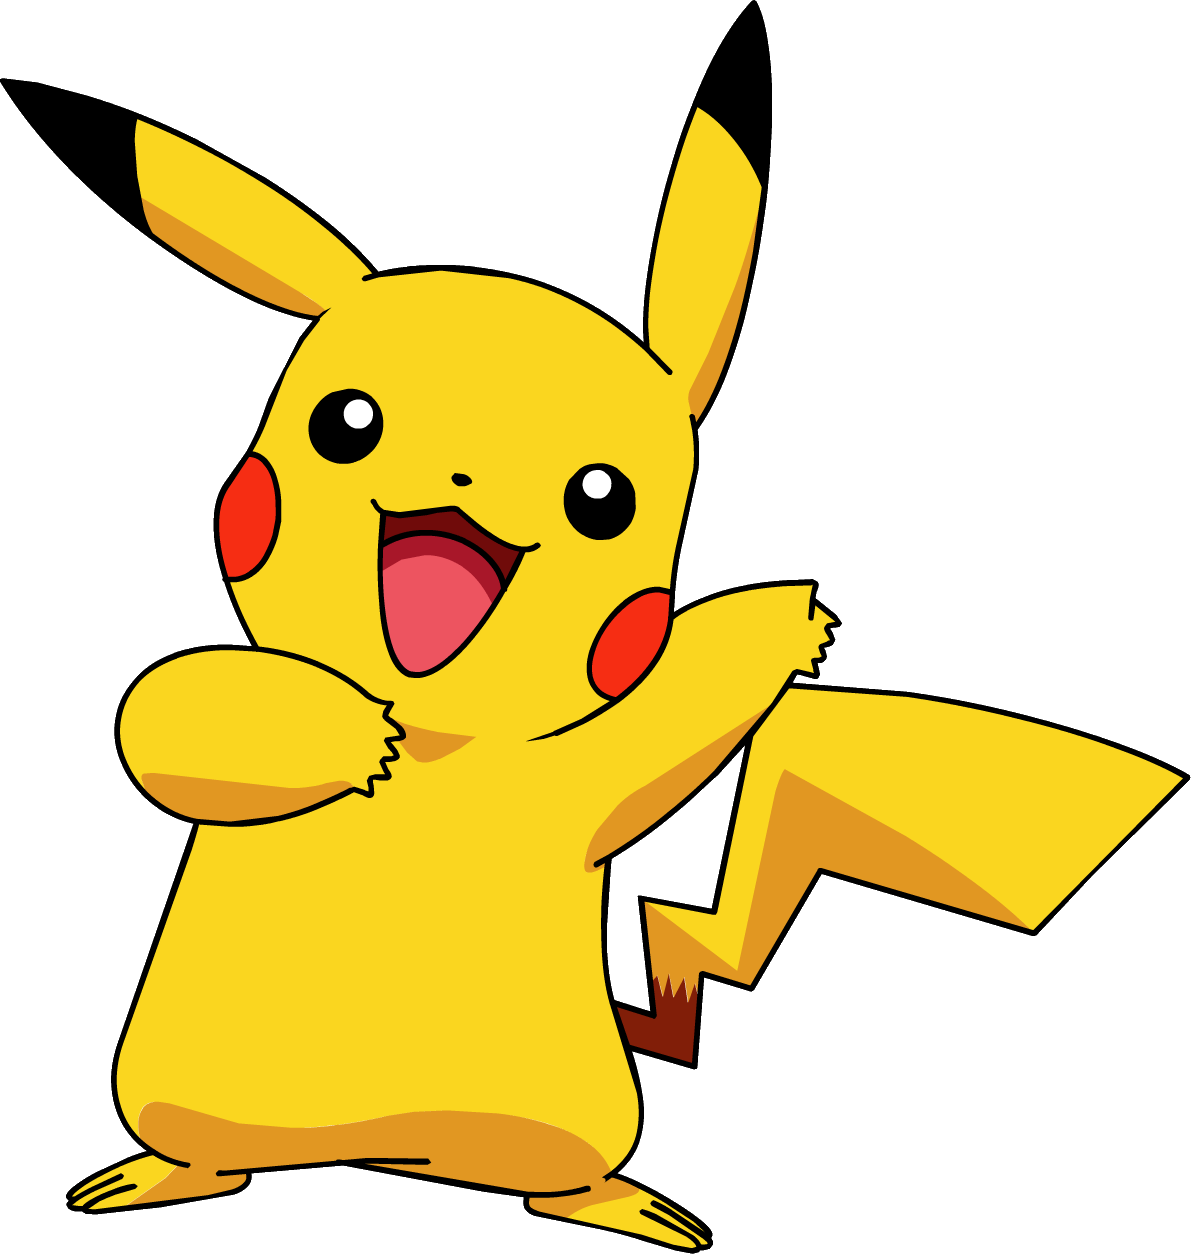
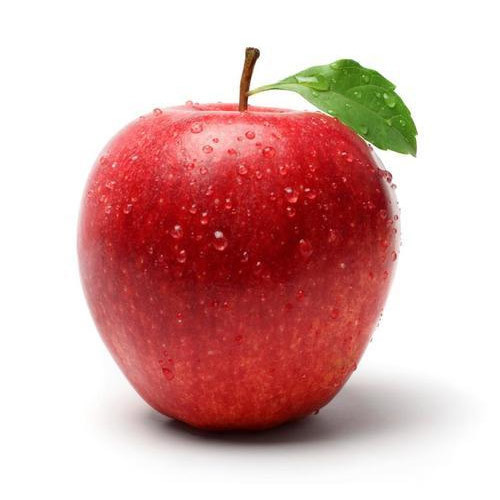
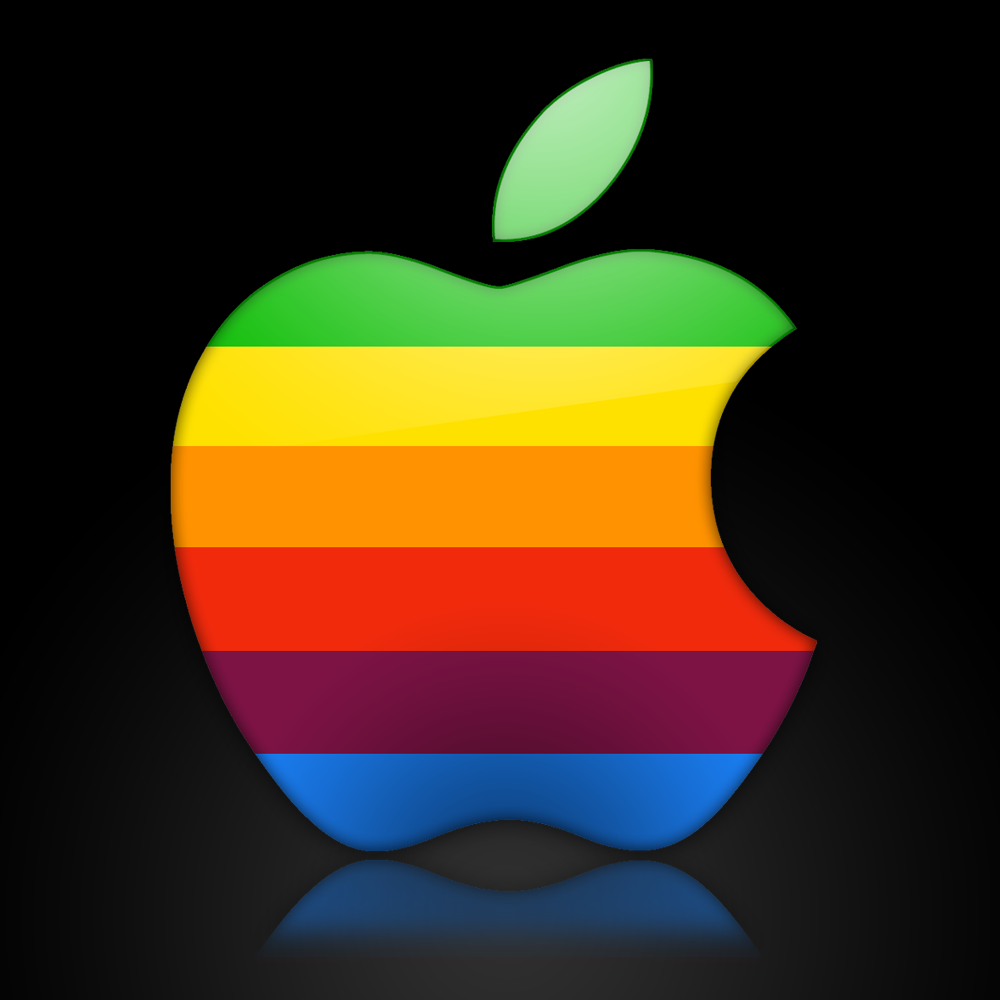
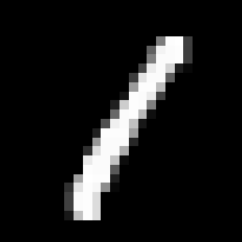

In [15]:
# Specify the paths to your images
image_paths = ['Images/guacamole.png', 'Images/fight.png',  'Images/aerith.png',  
               'Images/pikachu.png',  'Images/apple.png', 'Images/rainbow apple.png', 'Images/one.png']
# give some text for your pictures
texts = ["White background", "Black background", "Colorful background"]
display_similarity(image_paths, texts, 'image')

# Experiment 2: Position
- Very bad, do not use CLIP for position

In [16]:
# Create squares using matplotlib
import matplotlib.pyplot as plt
import numpy as np

def add_border(input_image, border_size = 1, border_color = (0, 0, 0)):
    """
    Adds a border around an input image with the given size and color.
    
    :param input_image: NumPy array of the image.
    :param border_size: Border width in pixels.
    :param border_color: Border color as a tuple (R, G, B).
    :return: Image with the border as a NumPy array.
    """
    # Calculate the new image size (original + border on all sides)
    new_height = input_image.shape[0] + 2 * border_size
    new_width = input_image.shape[1] + 2 * border_size
    # Create a new image with the border, filled with the border color
    bordered_image = np.ones((new_height, new_width, 3)) * border_color
    # Place the original image in the center
    bordered_image[border_size:-border_size, border_size:-border_size] = input_image
    
    return bordered_image

# Function to create the images
def create_image(position, color):
    # Create a blank white image
    image = np.ones((90, 90, 3))
    
    # Define the blue square's color
    if color == 'red': color = np.array([1, 0, 0])
    elif color == 'green': color = np.array([0, 1, 0])
    else: color = np.array([0, 0, 1])
    
    # Positions of the blue square
    positions = {
        'top left': (0, 0),
        'top middle': (0, 30),
        'top right': (0, 60),
        'middle left': (30, 0),
        'center': (30, 30),
        'middle right': (30, 60),
        'bottom left': (60, 0),
        'bottom middle': (60, 30),
        'bottom right': (60, 60),
    }
    
    # Get the starting position of the square
    start_row, start_col = positions[position]
    
    # Color the square in blue
    image[start_row:start_row+30, start_col:start_col+30, :] = color
    
    return image

# Positions where the blue square will be placed
# positions = [
#     'top left', 'top middle', 'top right',
#     'middle left', 'center', 'middle right',
#     'bottom left', 'bottom middle', 'bottom right'
# ]
positions = ['top left', 'top right', 'center', 'bottom left', 'bottom right']

for color in ['red', 'green', 'blue']:
    # Create and save each image
    for i, position in enumerate(positions, start=1):
        img = create_image(position, color)
        # add border
        # Assuming you have an image 'img'
        img = add_border(img)
        plt.figure(figsize=(2,2))
        plt.imshow(img)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"Images/{color}_square_{position.replace(' ', '_')}.png", bbox_inches='tight', pad_inches = 0)
        plt.close()

    # Generate the filenames of saved images
    image_paths = [f"Images/{color}_square_{position.replace(' ', '_')}.png" for position in positions]


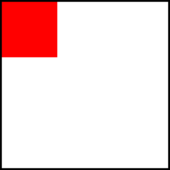
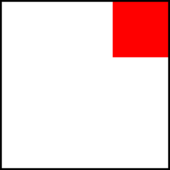
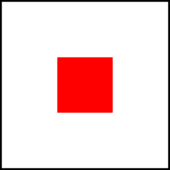
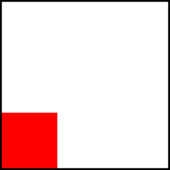
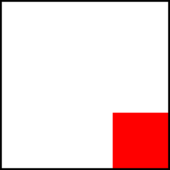

In [17]:
color = 'red'
texts = [f'a picture of {color} square at ' + position for position in positions]
image_paths = [f"Images/{color}_square_{position.replace(' ', '_')}.png" for position in positions]
display_similarity(image_paths, texts)


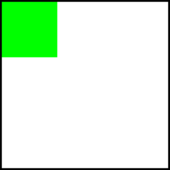
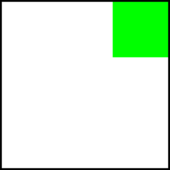
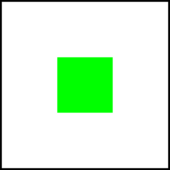
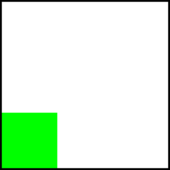
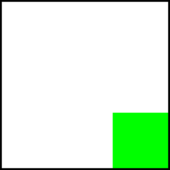

In [18]:
color = 'green'
texts = [f'a picture of {color} square at ' + position for position in positions]
image_paths = [f"Images/{color}_square_{position.replace(' ', '_')}.png" for position in positions]
display_similarity(image_paths, texts)


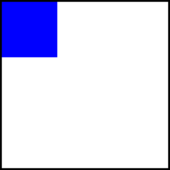
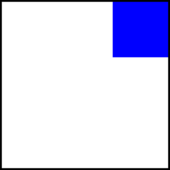
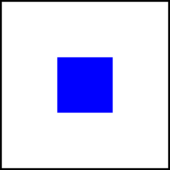
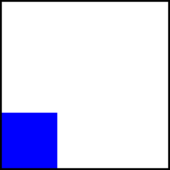
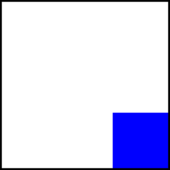

In [19]:
color = 'blue'
texts = [f'a picture of {color} square at ' + position for position in positions]
image_paths = [f"Images/{color}_square_{position.replace(' ', '_')}.png" for position in positions]
display_similarity(image_paths, texts)

## Do the same thing for an image

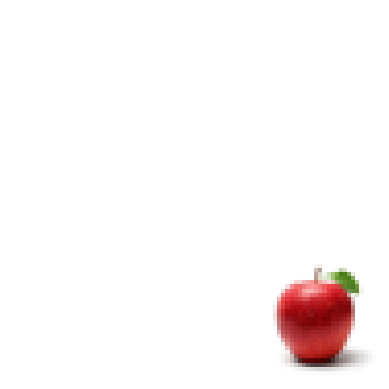

In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to place an image in a specific position in a grid
def place_image_on_grid(grid, img, row, col, grid_size=30):
    start_row, start_col = row * grid_size, col * grid_size
    grid[start_row:start_row+grid_size, start_col:start_col+grid_size] = img
    return grid

# Load and resize the image
img_name = 'apple'
img_path = f'Images/{img_name}.png'
img = Image.open(img_path)
img_resized = img.resize((30, 30))
img_array = np.array(img_resized)

# Check if the image is RGBA and convert to RGB
if img_array.shape[-1] == 4:
    img_array = img_array[..., :3]


# Positions of the apple image
positions = {
    'top left': (0, 0),
    'top middle': (0, 1),
    'top right': (0, 2),
    'middle left': (1, 0),
    'center': (1, 1),
    'middle right': (1, 2),
    'bottom left': (2, 0),
    'bottom middle': (2, 1),
    'bottom right': (2, 2),
}
    
# Place the image in each position of the 3x3 grid
for position, (row, col) in positions.items():
    # Create a blank canvas
    canvas_size = 90  # Since 3*30 = 90 for a 3x3 grid of 30x30 images
    canvas = np.ones((canvas_size, canvas_size, 3), dtype=np.uint8) * 255  # White canvas
    canvas = place_image_on_grid(canvas, img_array, row, col)
    
    plt.figure(figsize=(2,2))
    plt.imshow(canvas)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"Images/{img_name}_{position.replace(' ', '_')}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

# Display the canvas
plt.imshow(canvas)
plt.axis('off')  # Hide axis
plt.show()


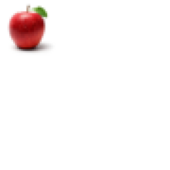
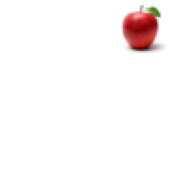
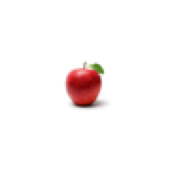
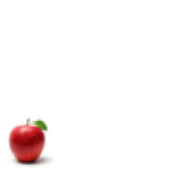
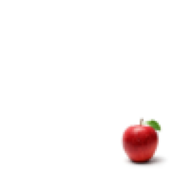

In [21]:
texts = ['a picture of apple at ' + position for position in ['top left', 'top right', 'center', 'bottom left', 'bottom right']]
image_paths = [f"Images/apple_{position.replace(' ', '_')}.png" for position in ['top left', 'top right', 'center', 'bottom left', 'bottom right']]
display_similarity(image_paths, texts)

# Experiment 3: Color
- Works pretty all right if only the color is mentioned without other details
- Does not work well for white / black

In [22]:
# Create squares using matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Function to create the images
def create_image(color):
    # Create a blank white image
    image = np.ones((90, 90, 3))
    
    if color == 'red': color = np.array([1, 0, 0])
    elif color == 'green': color = np.array([0, 1, 0])
    elif color == 'blue': color = np.array([0, 0, 1])
    elif color == 'yellow': color = np.array([1, 1, 0])
    elif color == 'magenta': color = np.array([1, 0, 1])
    elif color == 'cyan': color = np.array([0, 1, 1])
    elif color == 'black': color = np.array([0, 0, 0])
    elif color == 'white': color = np.array([1, 1, 1])
    
    # Color the square in blue
    image[:, :] = color
    
    return image

for color in ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'black', 'white']:
    # Create and save each image
    img = create_image(color)
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"Images/{color}_square.png", bbox_inches='tight', pad_inches = 0)
    plt.close()


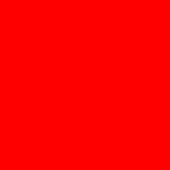
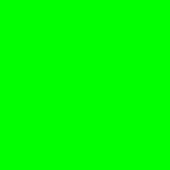
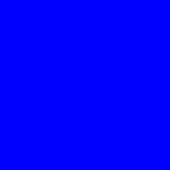
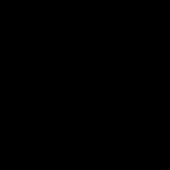
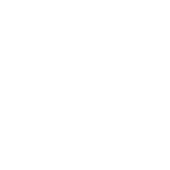

In [23]:
texts = ['a picture of ' + color + ' background' for color in ['red', 'green', 'blue', 'black', 'white']]
image_paths = [f"Images/{color}_square.png" for color in ['red', 'green', 'blue', 'black', 'white']]
display_similarity(image_paths, texts)

# Experiment 4: Text
- Character-level and word-level detection seems fine
- Higher-order thinking like how many characters may not be done well due to text tokeniser

In [24]:
from PIL import Image, ImageDraw, ImageFont

# Define the text and image size
texts_to_draw = ["hello", "bye", "clip", "clips", "1", "2", "3"]
for text in texts_to_draw:
    image_size = (50, 50)  # Width, height in pixels
    bg_color = "white"
    text_color = "black"

    # Create a blank image
    image = Image.new("RGB", image_size, bg_color)
    draw = ImageDraw.Draw(image)

    # For a custom font, replace None with the path to your font file, e.g., "arial.ttf"
    # font = ImageFont.truetype(None, size=20)

    # We just load default for now
    font = ImageFont.load_default()

    # Calculate text width and height
    text_width, text_height = draw.textsize(text, font=font)

    # Calculate the position at which to place the text
    text_x = (image_size[0] - text_width) / 2
    text_y = (image_size[1] - text_height) / 2

    # Place the text onto the image
    draw.text((text_x, text_y), text, fill=text_color, font=font)

    # Save the image
    image_path = f"Images/text_of_{text}.png"
    image.save(image_path)

/var/folders/73/8s7y80dd4s79cnmltvgc1n7r0000gn/T/ipykernel_2039/955464862.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
/var/folders/73/8s7y80dd4s79cnmltvgc1n7r0000gn/T/ipykernel_2039/955464862.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
/var/folders/73/8s7y80dd4s79cnmltvgc1n7r0000gn/T/ipykernel_2039/955464862.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
/var/folders/73/8s7y80dd4s79cnmltvgc1n7r0000gn/T/ipykernel_2039/955464862.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength inst


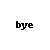
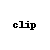
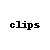
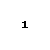
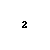

In [25]:
texts_to_draw = ["bye", "clip", "clips", "1", "2"]
texts = [f'a picture of "{text}"' for text in texts_to_draw]
image_paths = [f"Images/text_of_{text}.png" for text in texts_to_draw]
display_similarity(image_paths, texts)


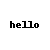
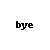
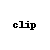
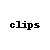
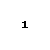
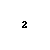
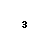

In [26]:
texts_to_draw = ["hello", "bye", "clip", "clips", "1", "2", "3"]
texts = ['a picture of a number', 'a picture of a word']
image_paths = [f"Images/text_of_{text}.png" for text in texts_to_draw]
display_similarity(image_paths, texts)


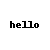
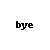
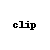
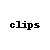
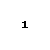
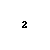
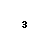

In [27]:
texts_to_draw = ["hello", "bye", "clip", "clips", "1", "2", "3"]
texts = ['a picture containing letter "e"', 'a picture containing letter "i"', 'a picture containing "1"', 'a picture containing "2"', 'a picture containing "3"']
image_paths = [f"Images/text_of_{text}.png" for text in texts_to_draw]
display_similarity(image_paths, texts)


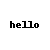
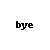
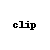
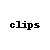

In [28]:
texts_to_draw = ["hello", "bye", "clip", "clips"]
texts = ['a picture with a three letter word', 'a picture with a four letter word', 'a picture with a five letter word']
image_paths = [f"Images/text_of_{text}.png" for text in texts_to_draw]
display_similarity(image_paths, texts)


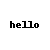
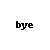
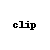
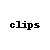

In [29]:
texts_to_draw = ["hello", "bye", "clip", "clips"]
texts = ['a greeting', 'an object']
image_paths = [f"Images/text_of_{text}.png" for text in texts_to_draw]
display_similarity(image_paths, texts)